![](logo_scanpy.svg){width=50% fig-align="center"}

scRNA-seq 기술의 발달로 개별 세포 수준에서의 유전자 발현 데이터를 얻는 것이 가능해졌습니다. 세포 수준의 데이터는 생명과학 연구에서 세포 유형 및 기능적 특성을 이해하는데 중요한 정보를 제공합니다. 그러나 동시에 데이터가 너무 방대하고 복잡해 새로운 분석 도구와 알고리즘이 필요하게 되었습니다. 이번 강좌는 `scanpy`를 활용하여 그래프 커뮤니티 감지 알고리즘을 통해 세포를 그룹화하고 각 세포 집단의 기능적 특성을 파악하는 방법을 살펴보겠습니다.

# 들어가며

이 글은 [NBIS workshop](https://nbisweden.github.io/workshop-scRNAseq) 자료를 기반으로 수정 및 번역 작업을 진행한 것입니다. 먼저 필요한 모든 라이브러리와 이전 단계에 생성한 h5ad 파일을 불러옵니다.


In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import rc_context
from matplotlib_venn import venn3_unweighted
from sklearn.cluster import AgglomerativeClustering, KMeans

# 경고 무시하기
warnings.filterwarnings("ignore")
sc.settings.n_jobs = -1
sc.settings.verbosity = 0  # 오류 (0), 경고 (1), 정보 (2), 힌트 (3)
sc.settings.set_figure_params(
    dpi=60, frameon=False, figsize=(5, 5), facecolor="white", color_map="viridis_r"
)
print(f"사용한 SCANPY 버전: {sc.__version__}")

사용한 SCANPY 버전: 1.10.1


In [2]:
adata = sc.read_h5ad("./output/covid/results/scanpy_covid_qc_dr_sc.h5ad")
print(f"데이터의 수: {adata.n_obs}, 유전자의 수: {adata.n_vars}")

데이터의 수: 7227, 유전자의 수: 19094


# 그래프 클러스터링

그래프 클러스터링하는 절차는 크게 3가지 단계로 일반화됩니다.

1. 데이터에서 KNN(K-Nearest Neighbors, 최근접 이웃) 그래프를 구축합니다.
2. KNN 그래프에서 허위 연결을 제거합니다(선택적 단계). 이것이 SNN(Spiking Neural Network) 그래프입니다.
3. 다른 그룹과 비교하여 그룹 내 연결이 최대화되는 세포 그룹을 찾습니다.

> KNN은 이 데이터와 가장 가까운 K개의 이웃 데이터들을 찾아서 이 데이터의 클래스 또는 값을 예측하는 방식입니다.

이전 강좌에서 UMAP을 실행하기 전에 이미 kNN 그래프를 구성했었기 때문에 이 작업을 다시 수행할 필요는 없습니다. 

`Scanpy`에서 기본 제공하는 클러스터링 알고리즘은 라이덴(Leiden)과 루바인(Louvain)이 있고 여기서는 총 4종류를 테스트해봅니다.

## 라이덴(Leiden)

라이덴은 루바인 알고리즘의 개선 버전으로 연결성과 높은 모듈성, 세분화 단계를 추가해 더 정확한 커뮤니티를 탐지하는 것으로 알려져 있습니다. 따라서 라이덴을 사용하는 것을 권장합니다.

In [5]:
sc.tl.leiden(adata, key_added="leiden_1.0")  # default resolution in 1.0
sc.tl.leiden(adata, resolution=0.6, key_added="leiden_0.6")
sc.tl.leiden(adata, resolution=0.4, key_added="leiden_0.4")
sc.tl.leiden(adata, resolution=1.4, key_added="leiden_1.4")

시각화를 해보면 설정된 해상도 값이 높아질수록 클러스터가 세분화 된다는 것을 알 수 있습니다.

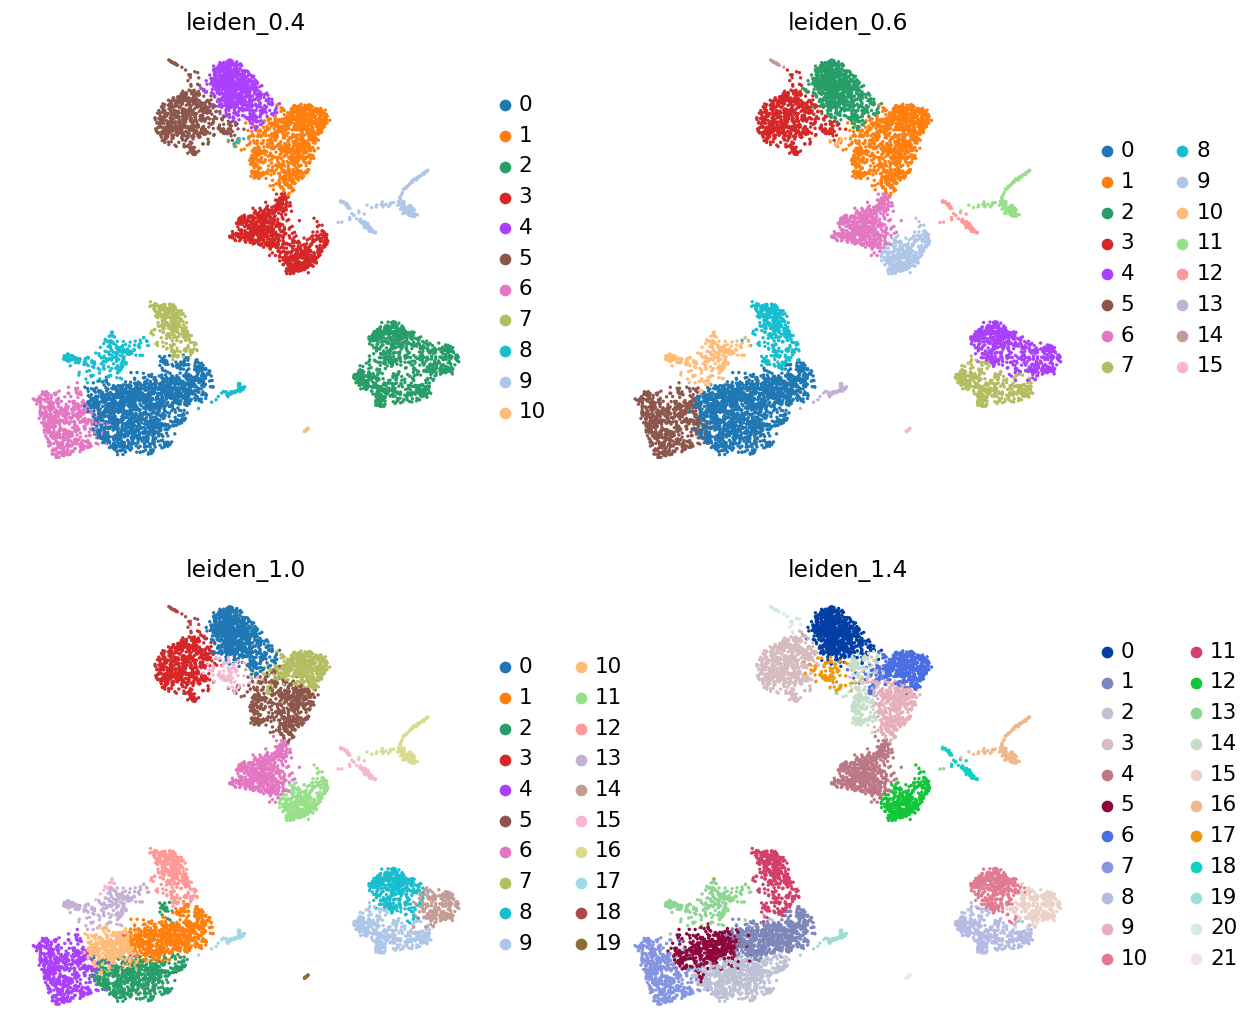

In [6]:
sc.pl.umap(
    adata,
    color=["leiden_0.4", "leiden_0.6", "leiden_1.0", "leiden_1.4"],
    ncols=2,
)

## 루바인(Louvain)

루바인 알고리즘은 네트워크 그래프에서 클러스터를 탐지하는 데 사용되는 방법으로 주로 네트워크 모듈성 최적화를 통해 작동됩니다.

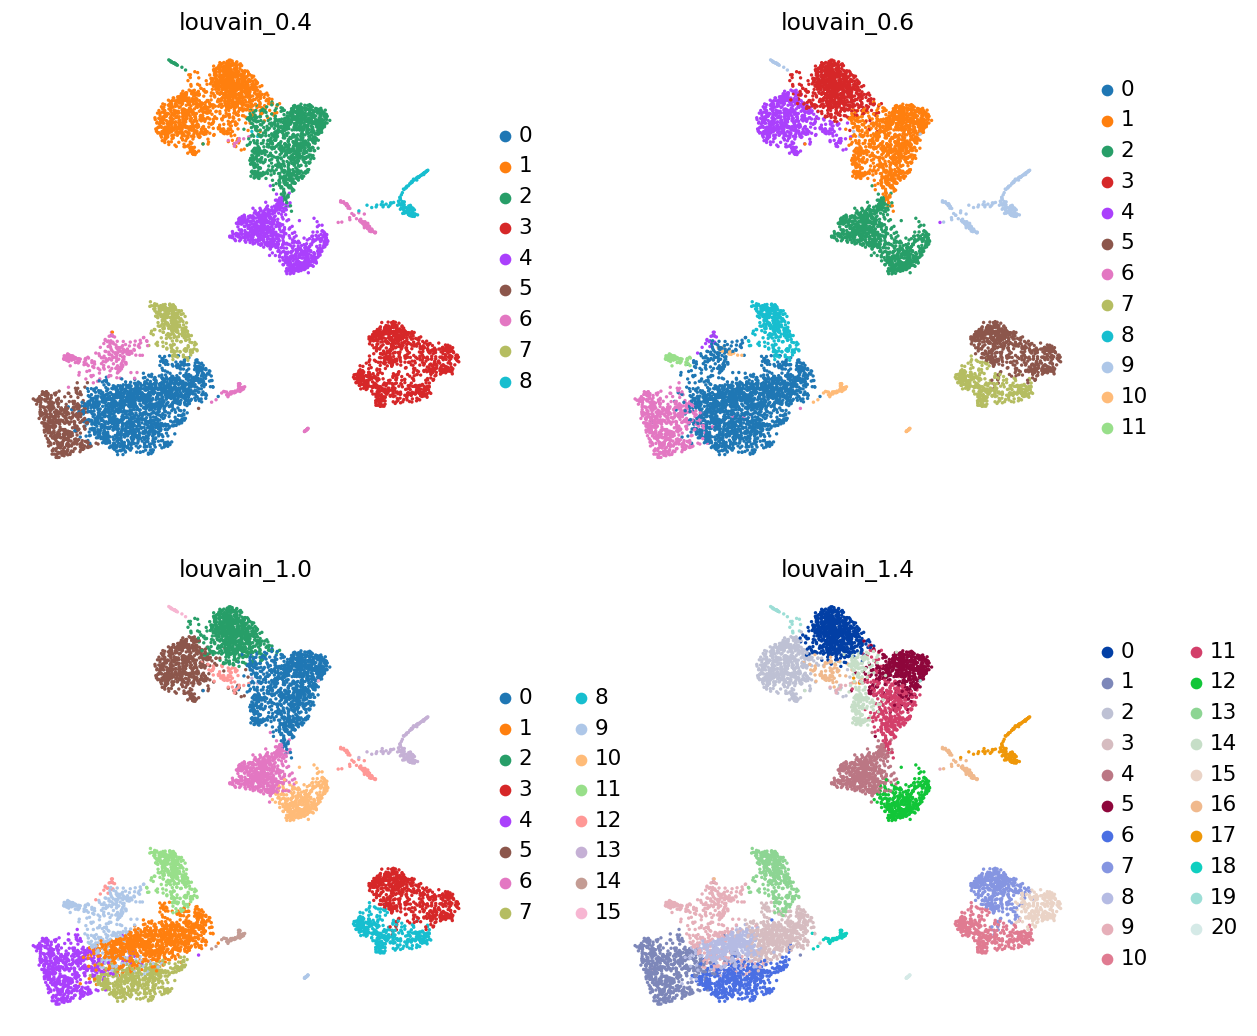

In [7]:
sc.tl.louvain(adata, key_added="louvain_1.0")  # default resolution in 1.0
sc.tl.louvain(adata, resolution=0.6, key_added="louvain_0.6")
sc.tl.louvain(adata, resolution=0.4, key_added="louvain_0.4")
sc.tl.louvain(adata, resolution=1.4, key_added="louvain_1.4")

sc.pl.umap(
    adata,
    color=["louvain_0.4", "louvain_0.6", "louvain_1.0", "louvain_1.4"],
    ncols=2,
)

루바인도 라이덴과 마찬가지로 해상도 값이 높아지면 클러스터가 세분화됩니다.

## K-평균 클러스터링

K-평균 클러스터링은 다양한 분야에서 일반적으로 사용되어온 전통적인 클러스터링 알고리즘입니다. 클러스터 수를 미리 정의해야 한다는 점이 다르며 클러스터링 결과는 초기 클러스터 중심 값(`nstart`)에 따라 달라지므로 여러가지 값으로 시도해보는 것이 좋습니다. 여기에서는 `scikit learn`패키지의 `KMeans`함수를 이용해 구현하겠습니다.

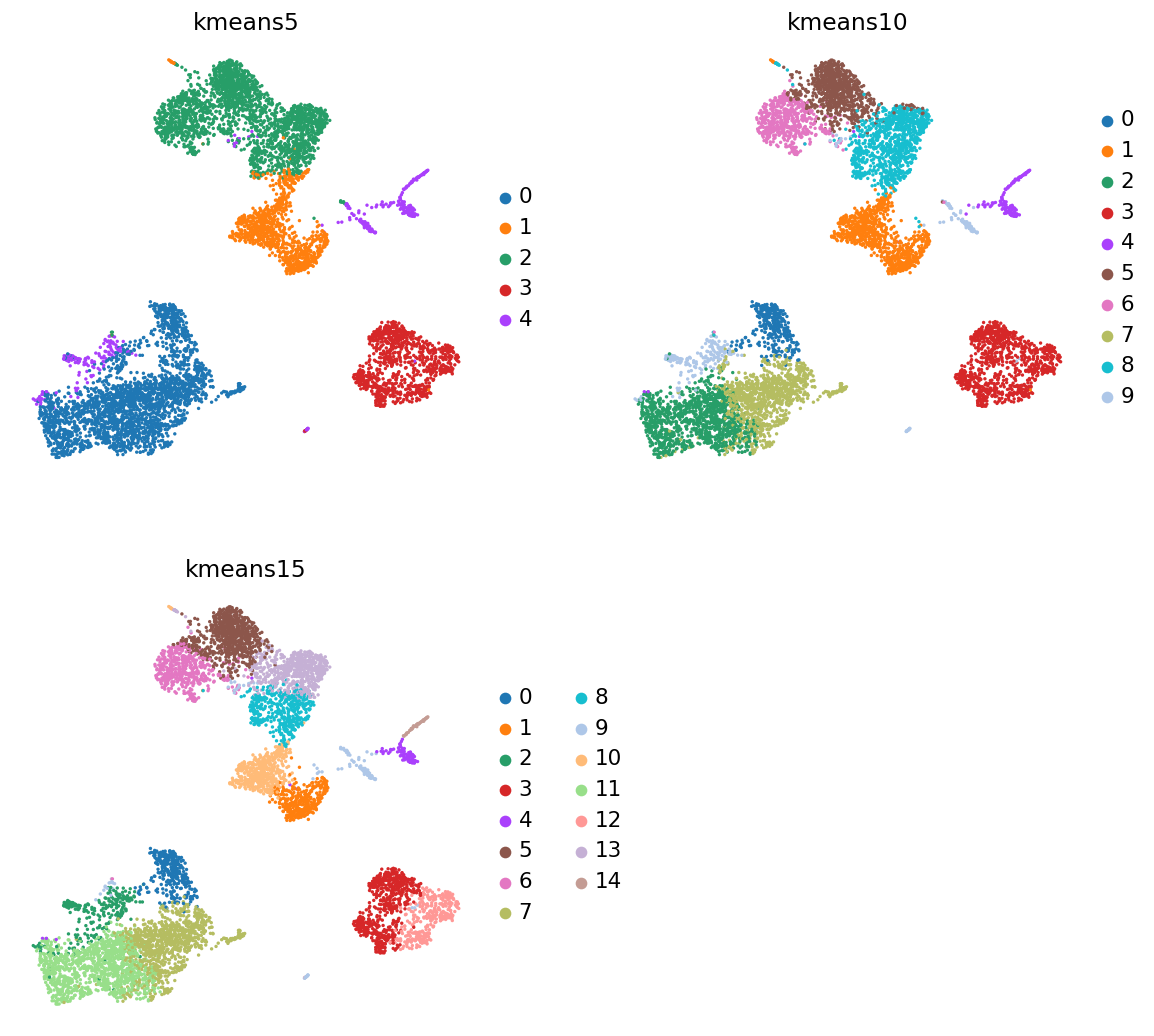

In [8]:
# 저장된 PCA값을 사용
X_pca = adata.obsm["Scanorama"]

# kmeans with k=5
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_pca)
adata.obs["kmeans5"] = kmeans.labels_.astype(str)

# kmeans with k=10
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_pca)
adata.obs["kmeans10"] = kmeans.labels_.astype(str)

# kmeans with k=15
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_pca)
adata.obs["kmeans15"] = kmeans.labels_.astype(str)

sc.pl.umap(
    adata,
    color=["kmeans5", "kmeans10", "kmeans15"],
    ncols=2,
)

## 계층적 클러스터링

또 다른 일반적인 형태의 클러스터링으로 계층적 클러스터링(Hierarchical clustering)을 사용해봅니다. 계층적 클러스터링은 다음 단계로 수행됩니다.

1. 샘플 사이의 거리를 정의합니다. 가장 일반적인 방법은 유클리드 거리(두 점 사이의 직선 거리) 또는 상관 계수입니다.
2. 클러스터 간 거리 측정값을 `연결` 기준이라고 정의합니다. 예를 들어 클러스터 간의 평균 거리가 될 수 있습니다. 일반적으로 사용되는 방법은 `단일`, `완전`, `평균`, `중앙값`, `중심` 및 `방향`입니다.
3. 상향식 또는 하향식 방식을 사용하여 전체 샘플 중 덴드로그램을 정의합니다. 상향식은 샘플이 자체 클러스터로 시작하여 하나의 클러스터만 남을 때까지 한 쌍씩 병합하는 방식입니다. 하향식은 샘플이 모두 동일한 클러스터에서 시작하여 각 샘플이 자체 클러스터를 가질 때까지 2개로 분할되는 방식입니다.

여기에서는 `scikit learn`패키지의 `AgglomerativeClustering`함수를 이용해 구현하겠습니다. K-평균 클러스터링과 마찬가지로 클러스터의 수를 지정해야 하며 사용된 매개변수인  `linkage="ward"`은 병합되는 클러스터의 편차를 최소화하기 위함입니다.

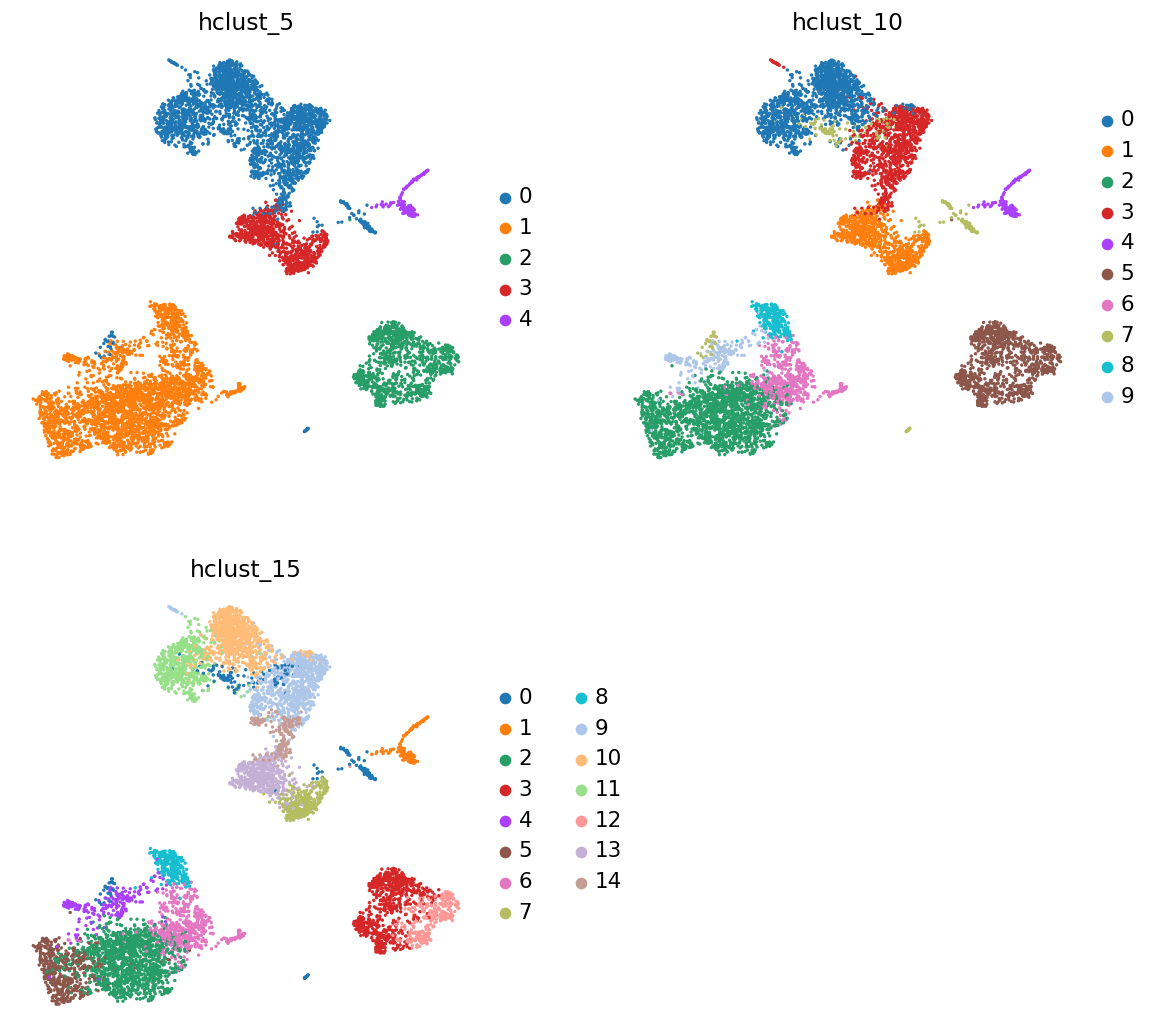

In [9]:
cluster = AgglomerativeClustering(n_clusters=5, linkage="ward")
adata.obs["hclust_5"] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=10, linkage="ward")
adata.obs["hclust_10"] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=15, linkage="ward")
adata.obs["hclust_15"] = cluster.fit_predict(X_pca).astype(str)

sc.pl.umap(adata, color=["hclust_5", "hclust_10", "hclust_15"], ncols=2)

# 클러스터 분포 시각화

이제 클러스터링 방법 중 하나를 선택하고 클러스터 전체에서 샘플의 비율을 비교할 수 있습니다.

> `resolution 0.6`의 클러스터링이 적당한 수의 클러스터를 제공하는 것 같으므로 이후 분석에 `leiden_0.6`값을 사용하겠습니다.

`leiden_0.6`을 선택하고 클러스터당 `covid` 대 `ctrl` 세포 비율과 `sample`의 비율을 시각화 해보겠습니다.

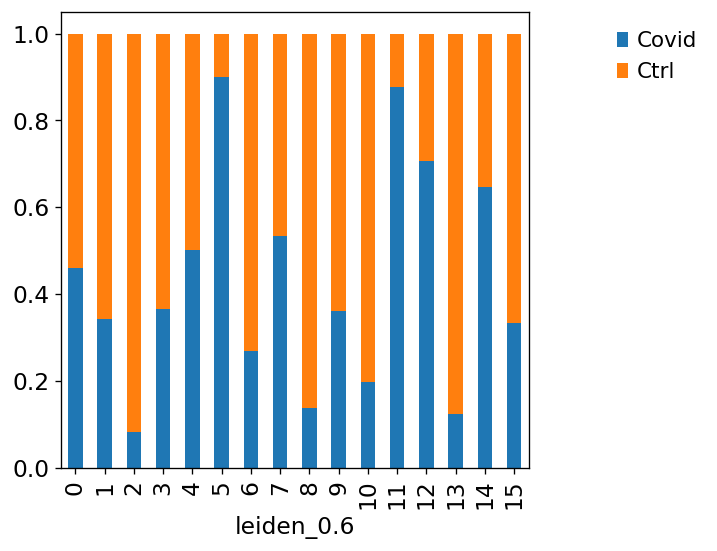

In [10]:
def plot_stacked_bar(data, index_col, columns_col, legend_position):
    tmp = pd.crosstab(data.obs[index_col], data.obs[columns_col], normalize="index")
    ax = tmp.plot.bar(stacked=True, grid=False)
    ax.legend(bbox_to_anchor=legend_position, loc="upper right", frameon=False)


# 첫 번째 그래프
plot_stacked_bar(adata, "leiden_0.6", "type", (1.4, 1))

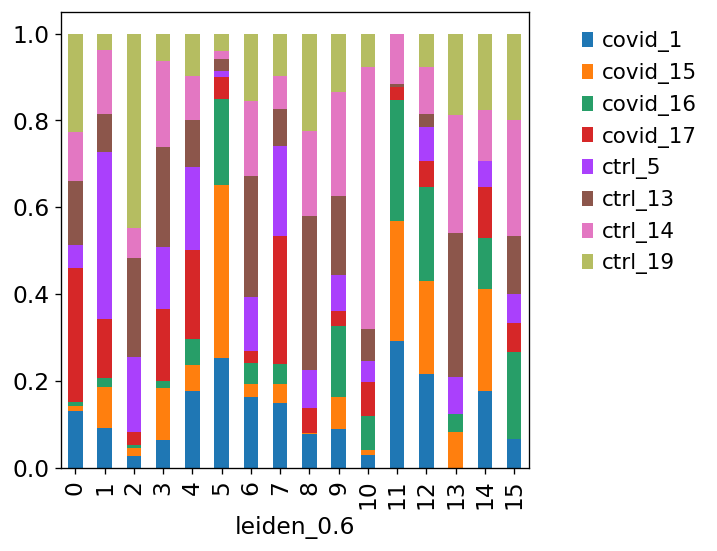

In [11]:
# 두 번째 그래프
plot_stacked_bar(adata, "leiden_0.6", "sample", (1.4, 1))

위 결과를 보면 클러스터당 각 샘플들이 고르게 분포하지만 일부 클러스터에는 특정 샘플이 더 많고 일부 클러스터에는 코로나 세포가 더 많은은 편향이 존재합니다. 다른 방향으로 샘플당 각 클러스터의 비율로 시각화를 해보죠.

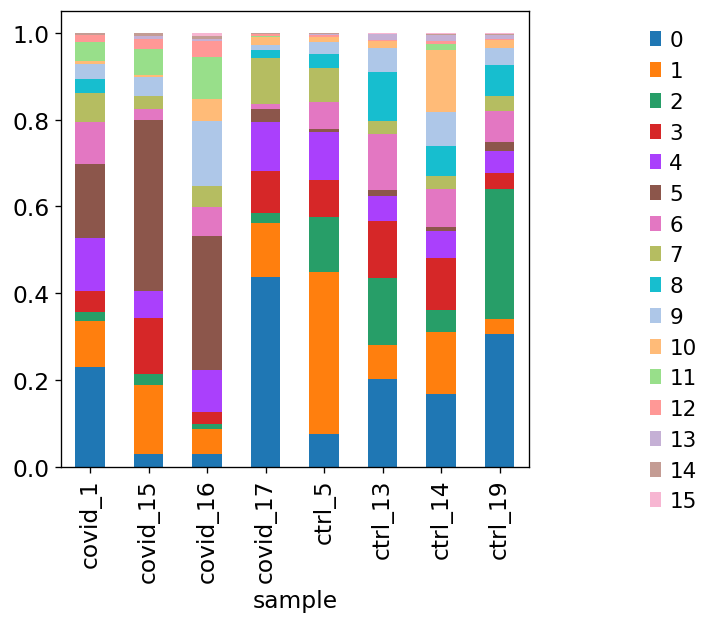

In [12]:
plot_stacked_bar(adata, "sample", "leiden_0.6", (1.4, 1))

# DEG 분석하기

단일 세포에서 DEG(Differentially Expressed Genes,유전자의 차등 발현)는 세포 집단에 대한 마커 유전자를 식별하고 조건(건강 대 대조군)에 따라 차등적으로 조절되는 유전자를 식별하는 등 다양한 기능을 수행할 수 있습니다. 

`scanpy`에서 DEG 분석은 `rank_genes_group` 함수를 사용하여 수행됩니다. 차등 발현을 계산하는 기본 메서드는 `t-test_overestim_var`입니다. 다른 구현된 방법으로는 `logreg`, `t-test` 및 `wilcoxon`이 있습니다.

:::{.callout-note}

여기에 있는 방법으로 DEG를 분석하는 방법은 여러 연구자들이 추천하지 않는 방법이지만, 학습의 편의를 위해 사용되었습니다. 제대로 하려면 `Peudo-bulk` 방법을 사용해야 한다는 것을 기억하세요.

:::

## T-test

`t-test`는 두 집단 간의 평균 차이를 비교하는 통계적 검정입니다. scRNA-seq 데이터에서는 두 그룹(예: 서로 다른 세포 유형 또는 조건) 간에 특정 유전자의 발현 수준이 유의하게 다른지 확인하는 데 사용됩니다.

- 장점: 간단하고 계산이 빠르며, 데이터가 정규 분포를 따를 때 강력한 성능을 발휘합니다.
- 단점: 데이터가 정규 분포를 따르지 않거나 분산이 다를 때 성능이 저하될 수 있습니다.

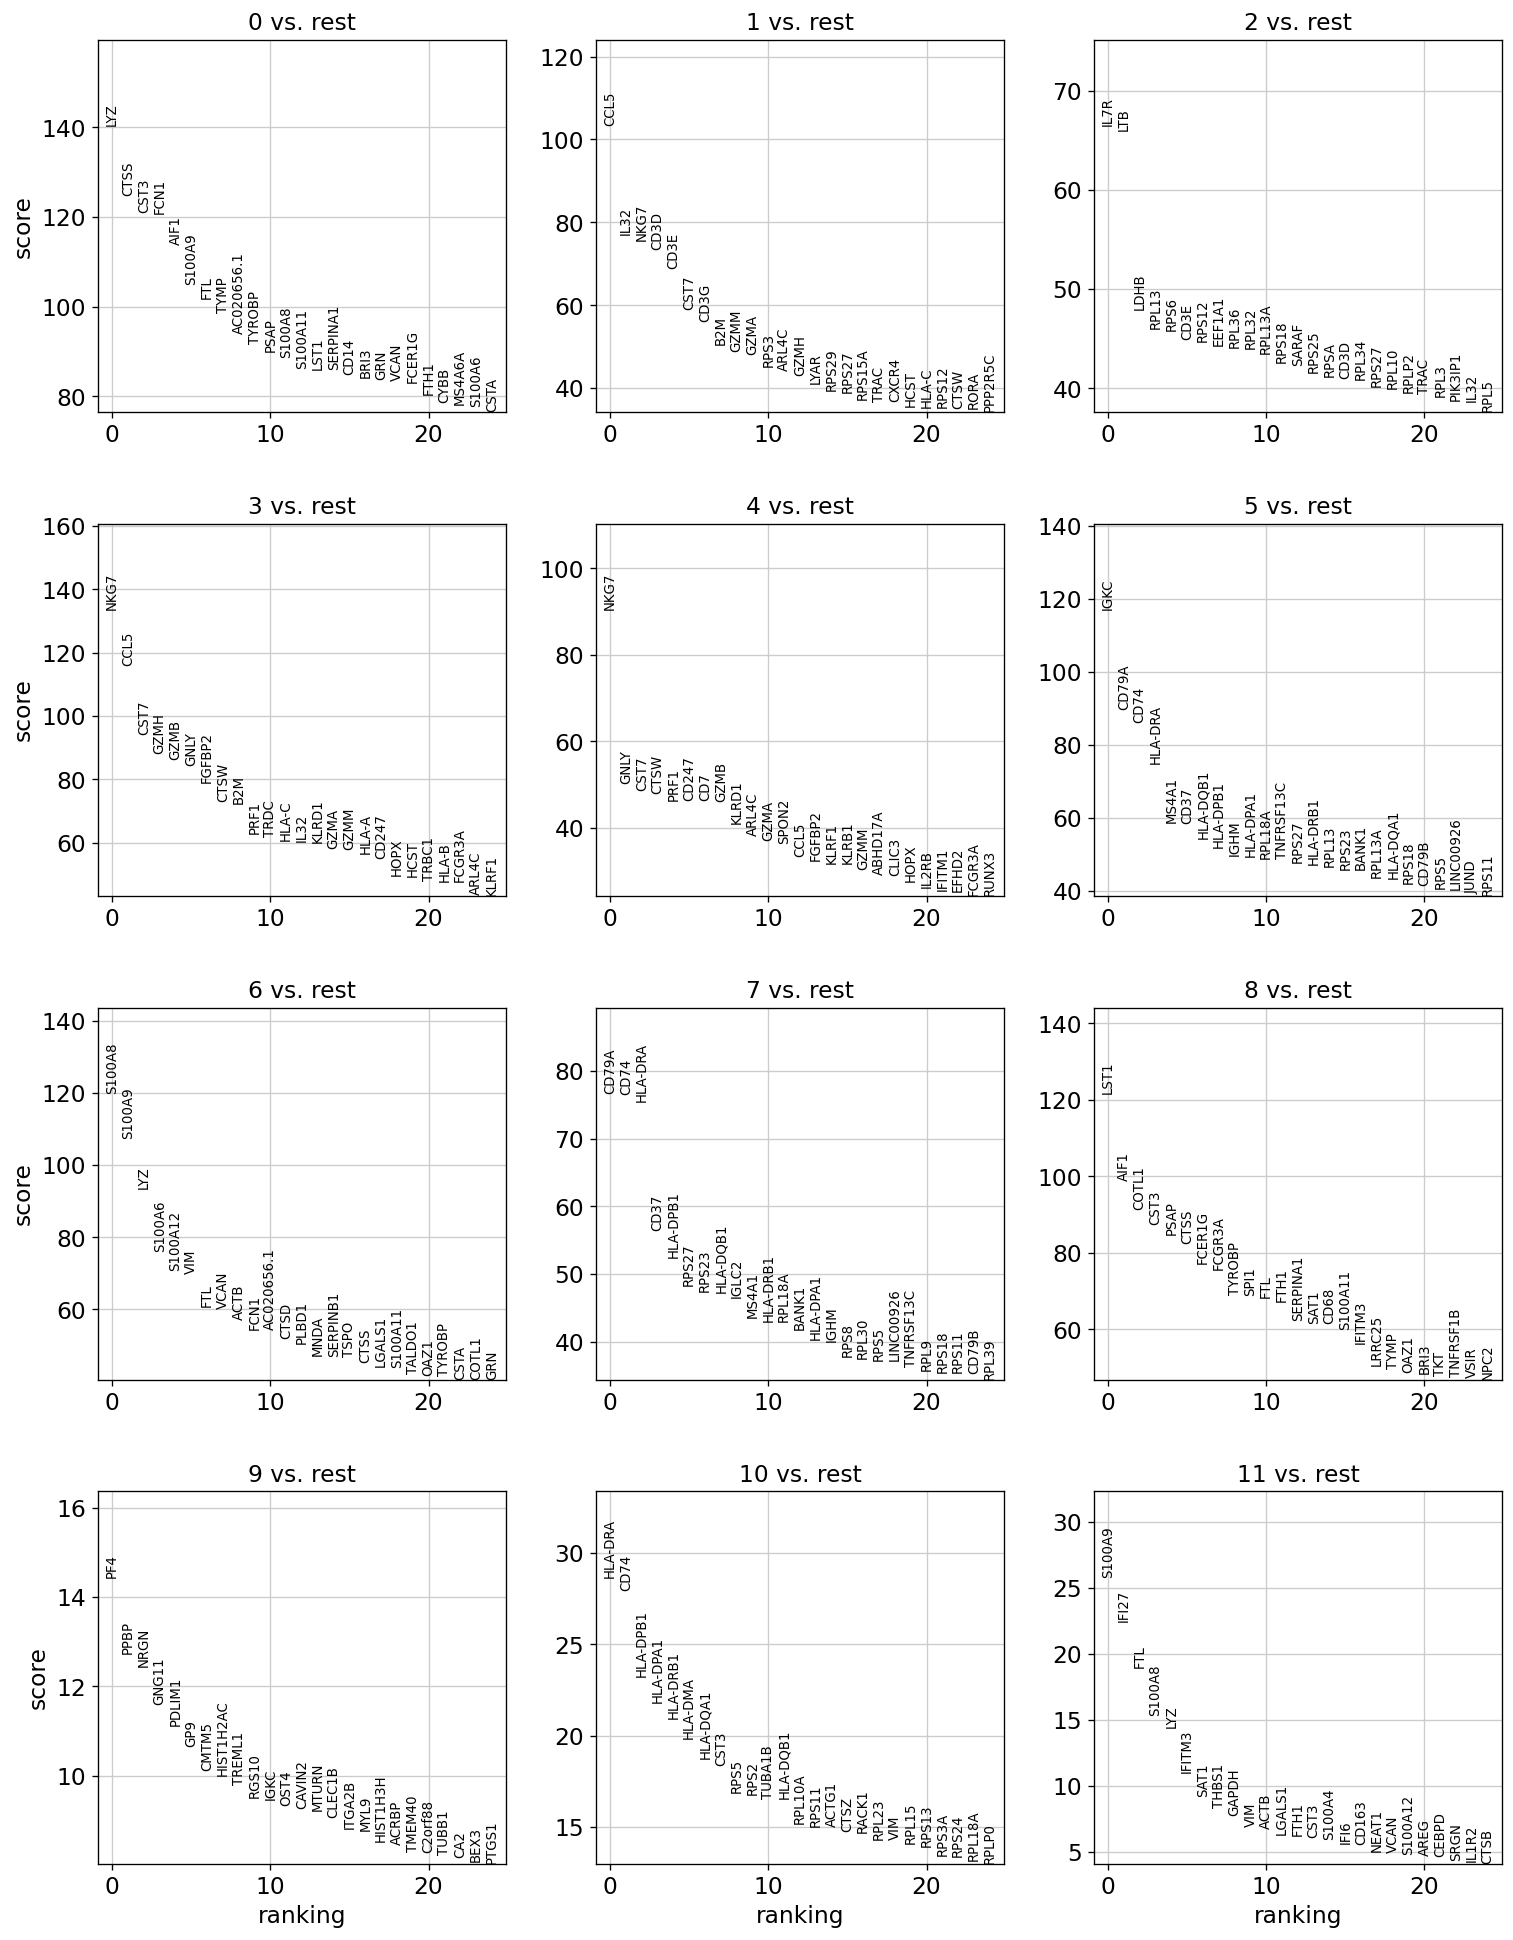

AnnData object with n_obs × n_vars = 7227 × 19094
    obs: 'type', 'sample', 'batch', 'n_counts', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'hclust_5', 'hclust_10', 'hclust_15'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'leiden_0.4_colors', 'leiden_0.6_colors', 'leiden_1.0_colors', 'leiden_1.4_colors', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_1.4', 'louvain_0.4_colors', 'louvain_0.6_colors', 'louvain_1.0_colors', 'louvain_1.4_colors', 'kmeans5_colors', 'kmeans10_colors', 'kmeans15_colors', 'hclust_5_colors', 'hclust_10_colors', 'hclust_15_colors', 't-test'
    obsm: 'Scanorama', 'X_pca', 'X_tsne

In [13]:
adata.X = adata.layers["log1p"].copy()

sc.tl.rank_genes_groups(adata, "louvain_0.6", method="t-test", key_added="t-test")
sc.pl.rank_genes_groups(
    adata,
    n_genes=25,
    sharey=False,
    key="t-test",
    ncols=3,
)

# 결과는 adata.uns["t-test"] 슬롯에 저장됩니다.
adata

## 과대추정 분산을 고려한 T-test

이 방법은 표준 t-test의 변형으로, 분산을 과대추정하여 보수적인 결과를 도출합니다. 이는 특히 소규모 표본에서 통계적 검정의 신뢰도를 높이는 데 도움이 됩니다.

- 장점: 소규모 표본에서의 검정의 신뢰도를 높이고, 분산이 과대추정될 때 발생할 수 있는 문제를 완화합니다.
- 단점: 분산을 과대추정함으로 인해 실제 차이가 있는 유전자도 덜 민감하게 검출될 수 있습니다.

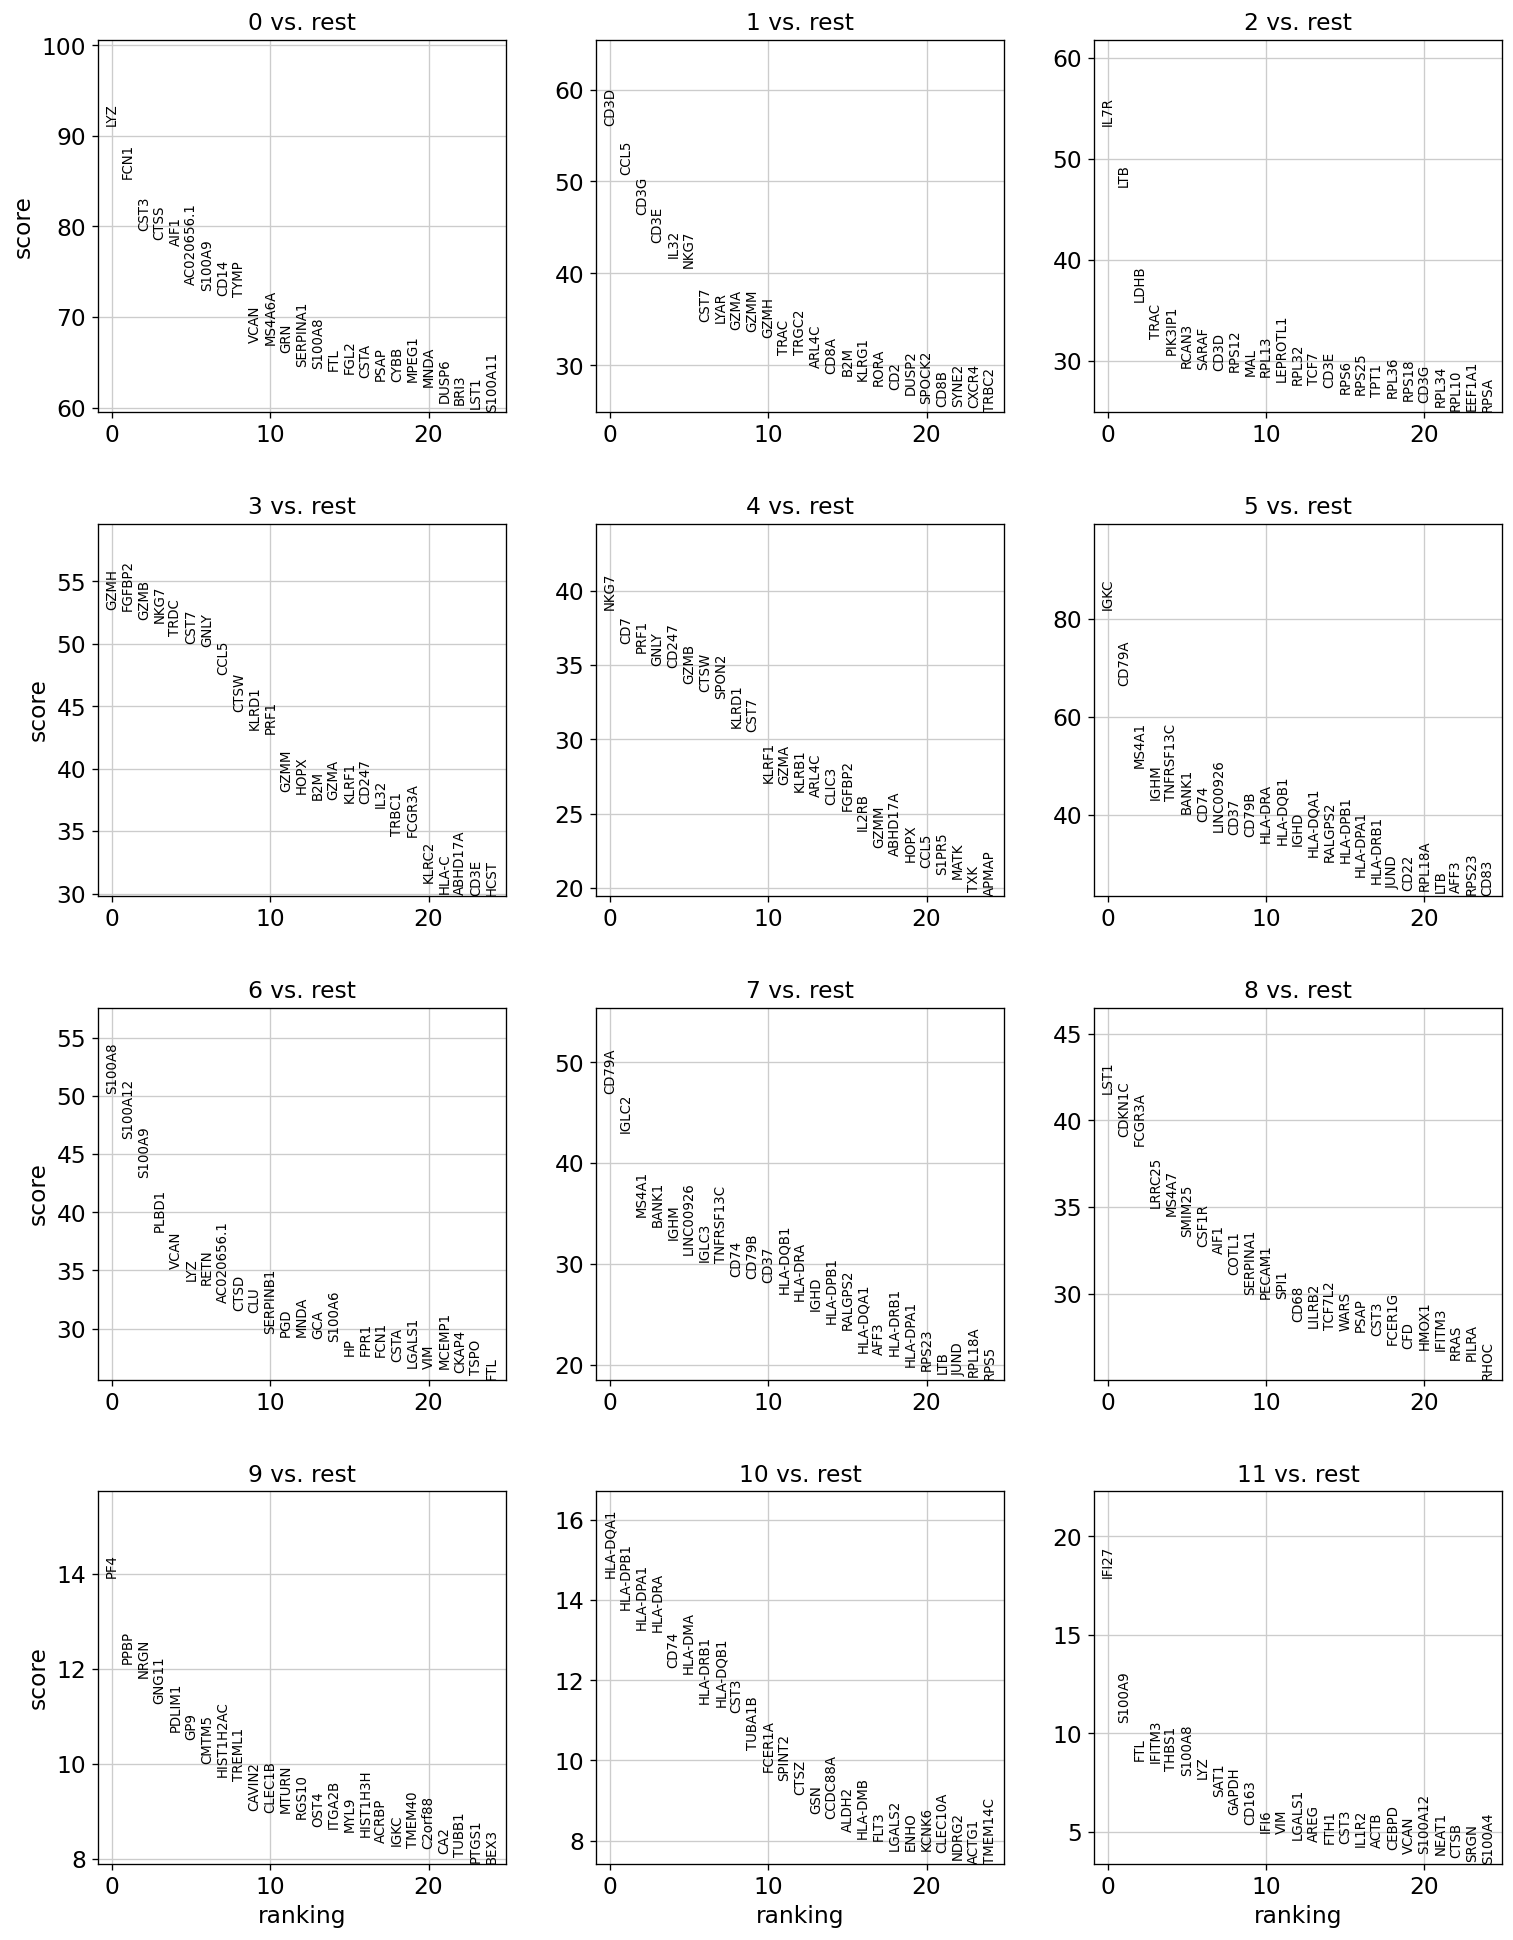

In [14]:
sc.tl.rank_genes_groups(adata, "louvain_0.6", method="t-test_overestim_var", key_added="t-test_ov")
sc.pl.rank_genes_groups(
    adata,
    n_genes=25,
    sharey=False,
    key="t-test_ov",
    ncols=3,
)

## 윌콕슨 순위 합계

윌콩슨(`wilcoxon`) 순위 합계 검정은 비모수 검정으로, 두 독립된 집단의 순위합을 비교하여 차이를 평가합니다. 이는 데이터가 정규 분포를 따르지 않을 때 유용합니다.

- 장점: 데이터가 정규 분포를 따르지 않아도 사용할 수 있으며, 이상치에 덜 민감합니다.
- 단점: 순위 기반 방법이기 때문에 데이터의 세밀한 차이를 반영하지 못할 수 있습니다.

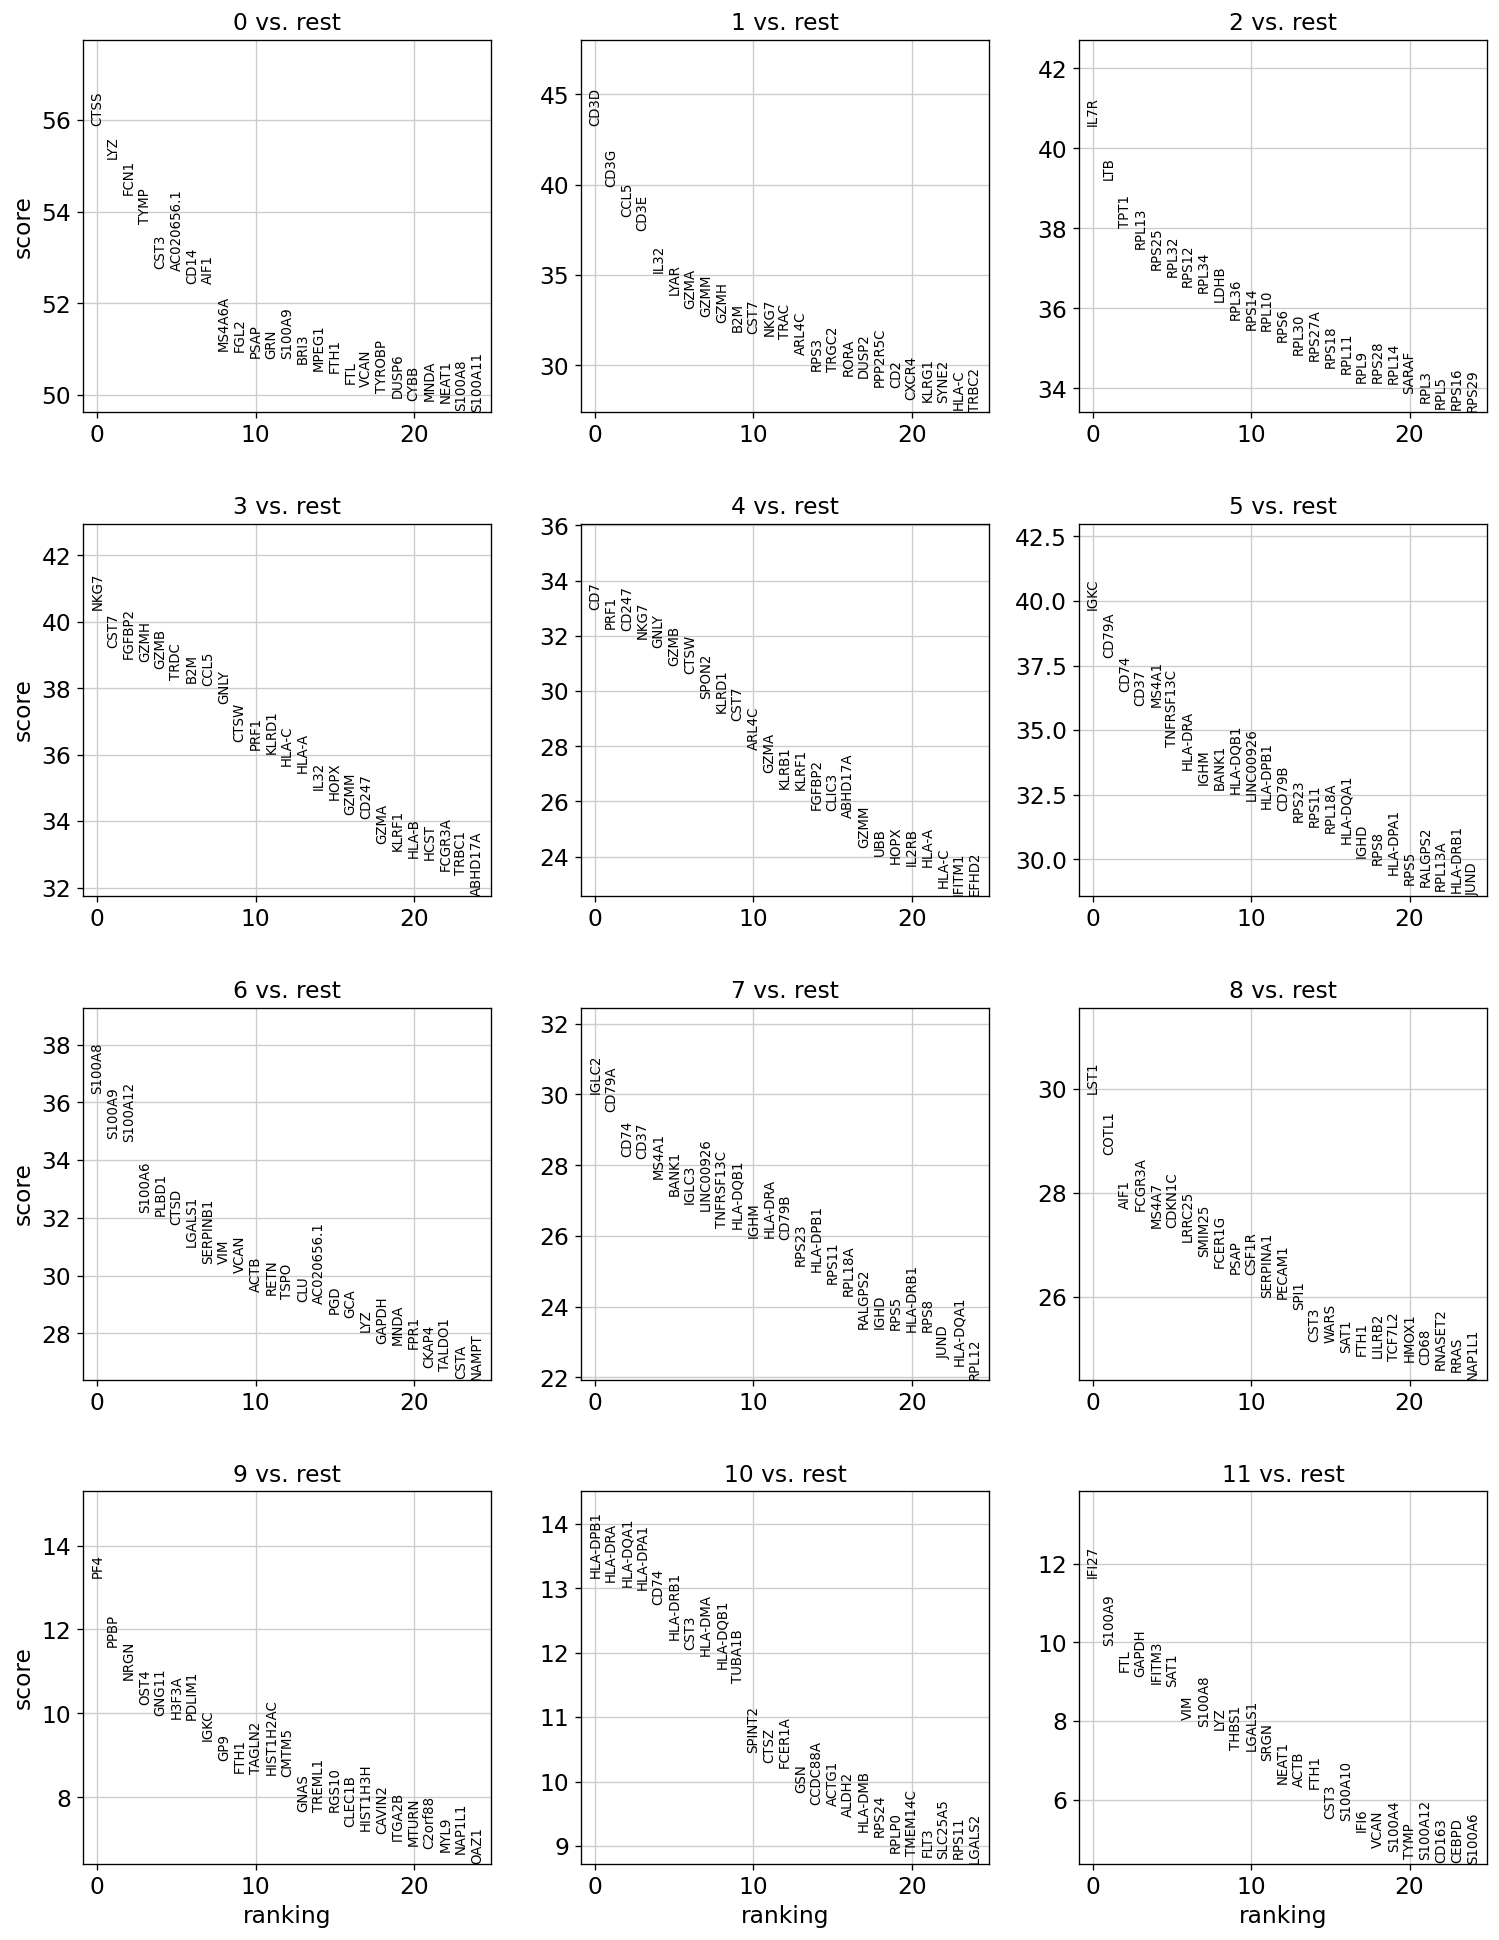

In [15]:
sc.tl.rank_genes_groups(adata, "louvain_0.6", method="wilcoxon", key_added="wilcoxon")
sc.pl.rank_genes_groups(
    adata,
    n_genes=25,
    sharey=False,
    key="wilcoxon",
    ncols=3,
)

## 유전자 리스트 비교

위에서 얻은 `T-test`, `T-test_ov`, `Wilcox` 결과를 비교해보죠. 클러스터 `0`에 대한 DEG 리스트를 가져와 벤다이어 그램을 그려봅니다.

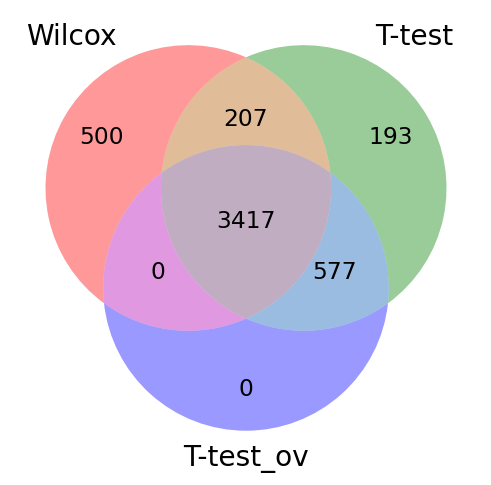

In [16]:
# cluster 0 DEG 비교, 기본적으로 상위 100개만 저장합니다.
wc = sc.get.rank_genes_groups_df(adata, group="0", key="wilcoxon", pval_cutoff=0.01, log2fc_min=0)[
    "names"
]
tt = sc.get.rank_genes_groups_df(adata, group="0", key="t-test", pval_cutoff=0.01, log2fc_min=0)[
    "names"
]
tt_ov = sc.get.rank_genes_groups_df(
    adata, group="0", key="t-test_ov", pval_cutoff=0.01, log2fc_min=0
)["names"]


venn3_unweighted([set(wc), set(tt), set(tt_ov)], ("Wilcox", "T-test", "T-test_ov"))
plt.show()

위 결과를에서 알수 있듯이 많은 DEG들은 중복됩니다. 특히 분산이 과대 추정된 T-test와 T-test 결과는 매우 유사합니다.

# DEG 시각화

상위 DEG의 발현을 시각화하는 방법에는 여러 가지가 있습니다. 여기서는 윌콕슨(Wilcox) 테스트 결과에 대한 히트맵, 닷플롯, 바이올린 플롯, 메트릭스플롯을 그려보겠습니다.

> `AnnData`의 `.raw` 속성이 없는 경우 매개변수 `use_raw=False`를 설정해야 합니다.

louvain_0.6 heatmap


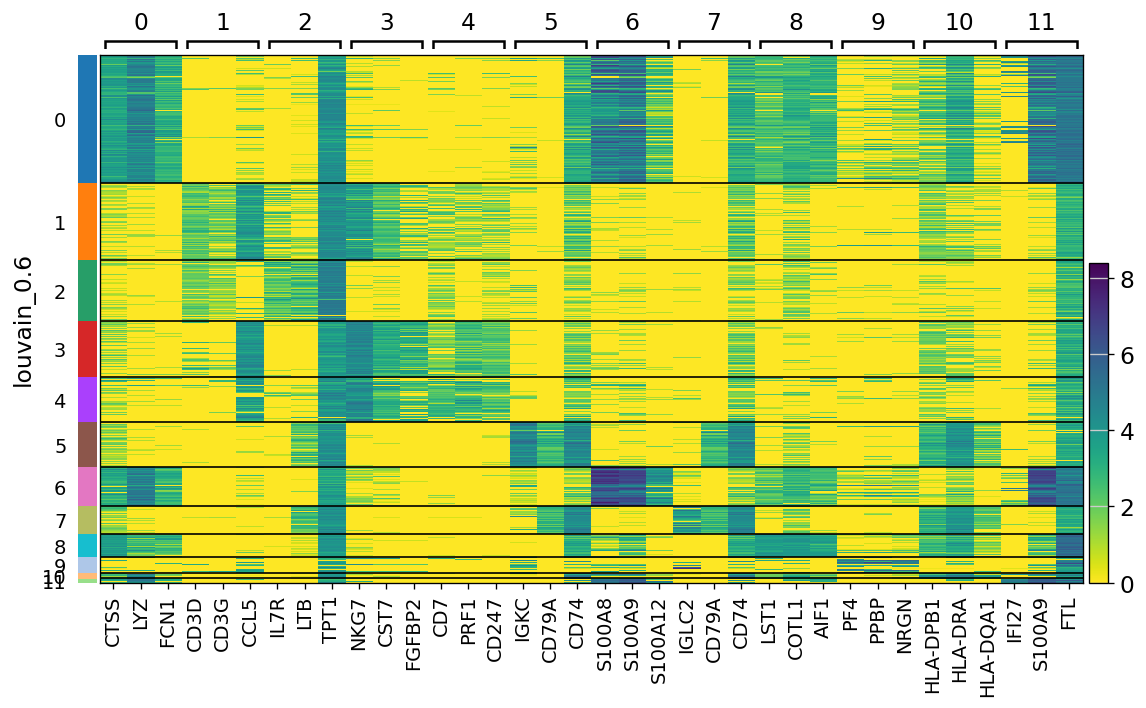

louvain_0.6 dotplot


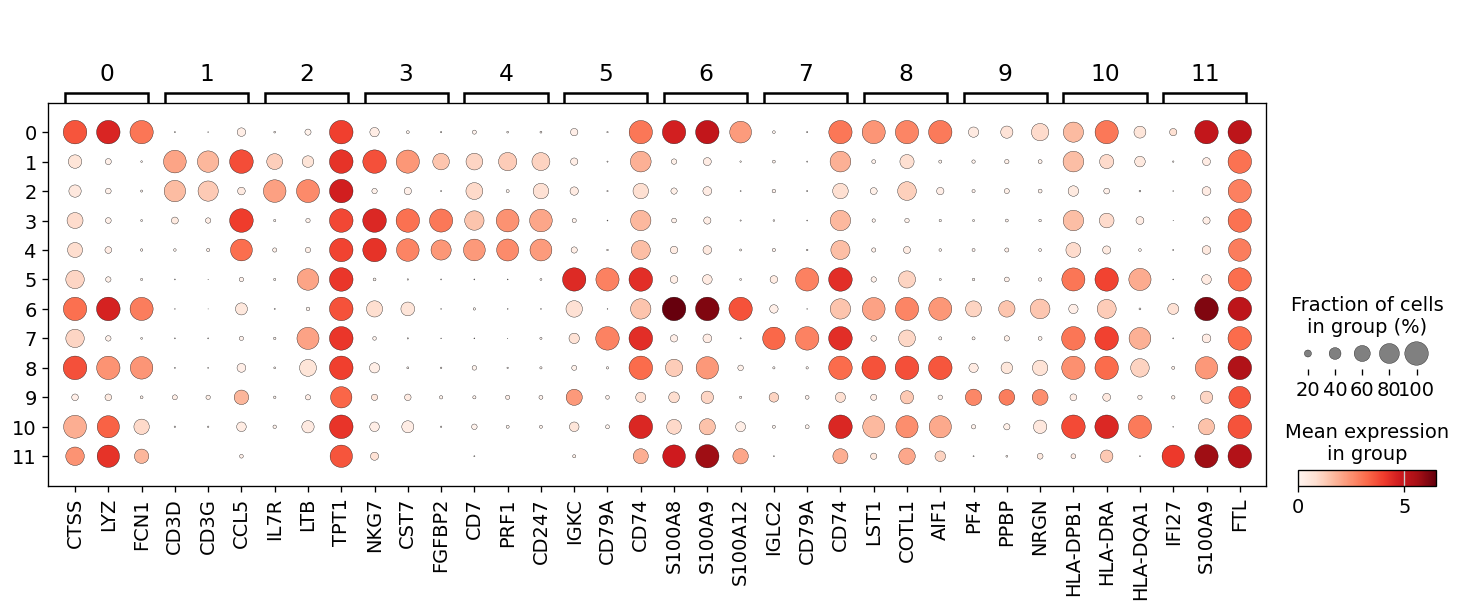

louvain_0.6 stacked_violin plot


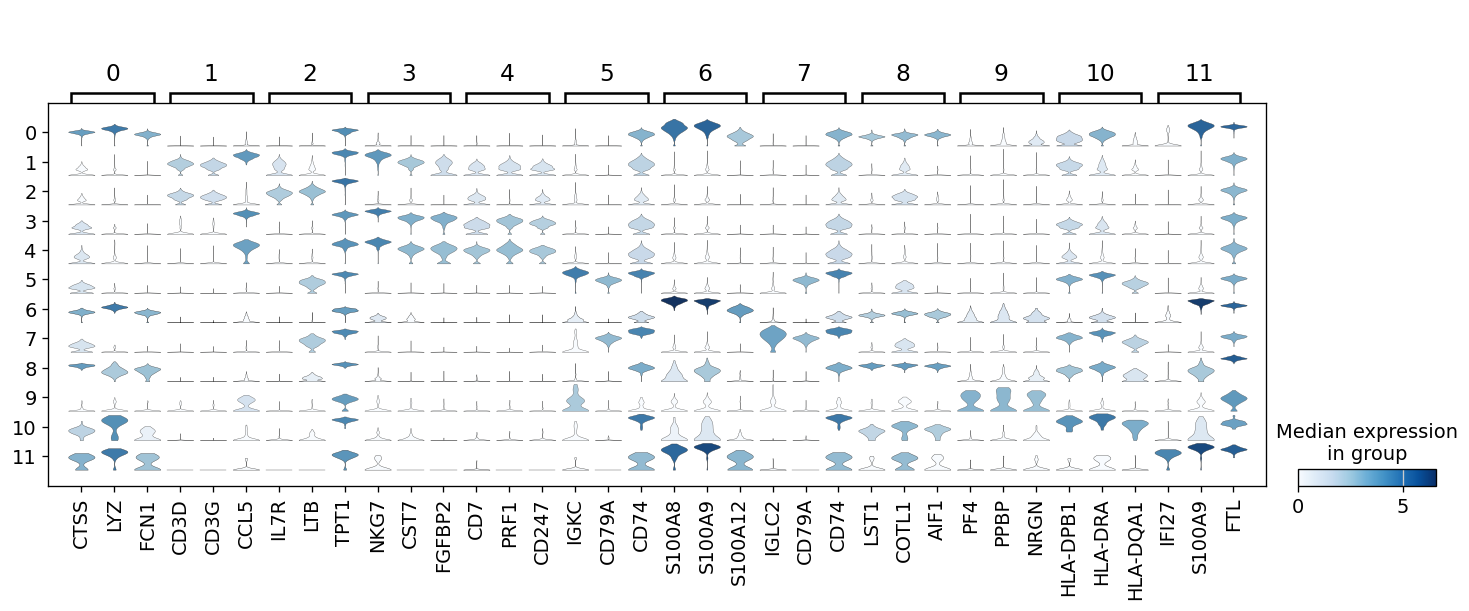

louvain_0.6 matrixplot


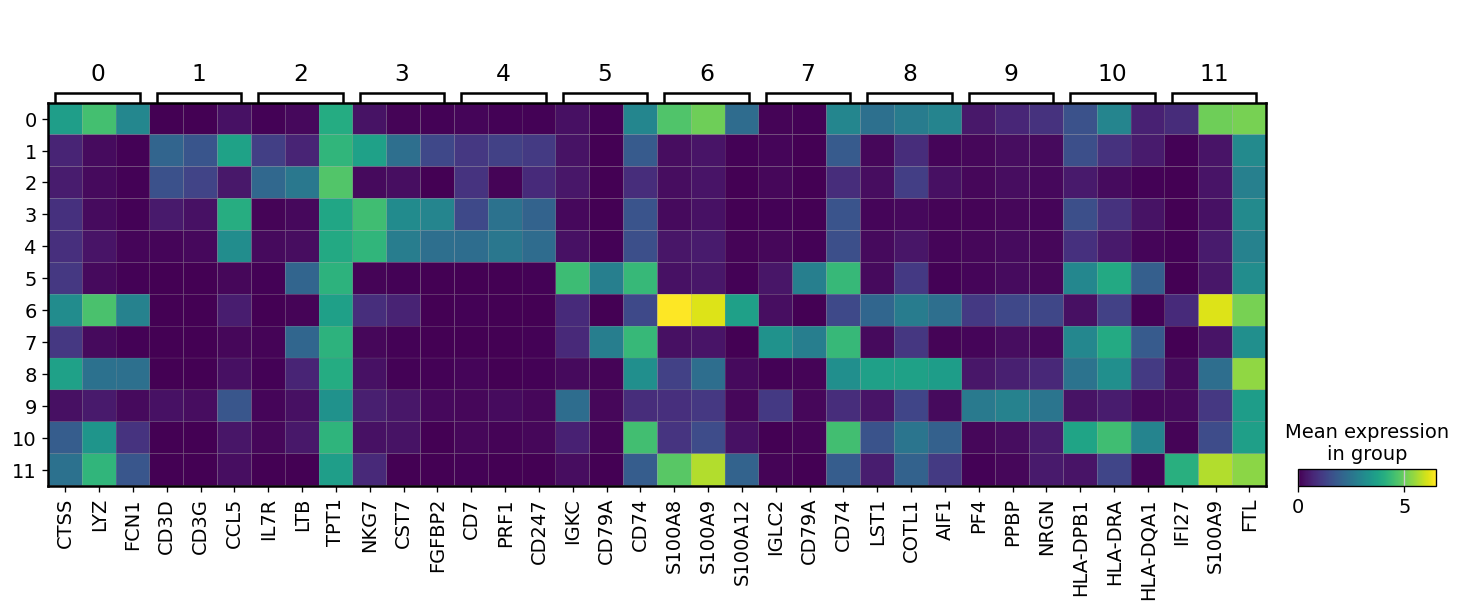

In [17]:
def plot_rank_genes_groups(adata, n_genes, key, groupby):
    print(f"{groupby} heatmap")
    sc.pl.rank_genes_groups_heatmap(
        adata,
        n_genes=n_genes,
        key=key,
        groupby=groupby,
        show_gene_labels=True,
        use_raw=False,
        dendrogram=False,
    )
    print(f"{groupby} dotplot")
    sc.pl.rank_genes_groups_dotplot(
        adata,
        n_genes=n_genes,
        key=key,
        groupby=groupby,
        use_raw=False,
        dendrogram=False,
    )
    print(f"{groupby} stacked_violin plot")
    sc.pl.rank_genes_groups_stacked_violin(
        adata,
        n_genes=n_genes,
        key=key,
        groupby=groupby,
        use_raw=False,
        dendrogram=False,
    )
    print(f"{groupby} matrixplot")
    sc.pl.rank_genes_groups_matrixplot(
        adata,
        n_genes=n_genes,
        key=key,
        groupby=groupby,
        use_raw=False,
        dendrogram=False,
    )


plot_rank_genes_groups(adata, n_genes=3, key="wilcoxon", groupby="louvain_0.6")

## 특정 클러스터간 비교

개별 클러스터를 하나의 클러스터 또는 여러 클러스터에 대해 쌍으로 비교할 수도 있습니다. 예를 들어, 클러스터 1과 2를 비교하는 방법은 아래와 같습니다.

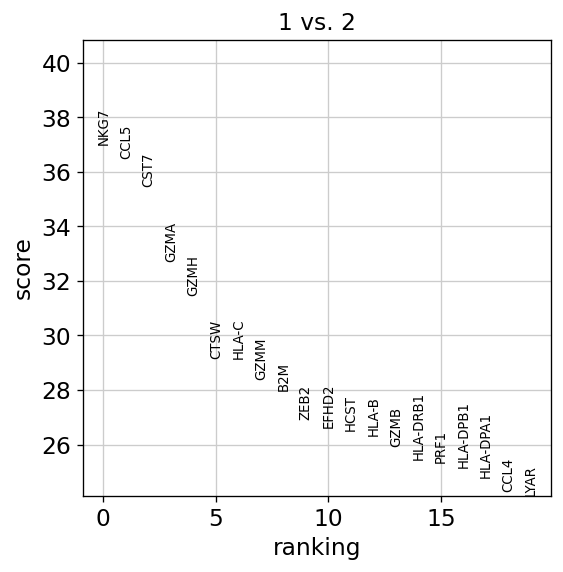

In [18]:
sc.tl.rank_genes_groups(
    adata,
    "louvain_0.6",
    groups=["1"],
    reference="2",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata, groups=["1"], n_genes=20)

이 두 그룹을 바이올린으로 플롯합니다.

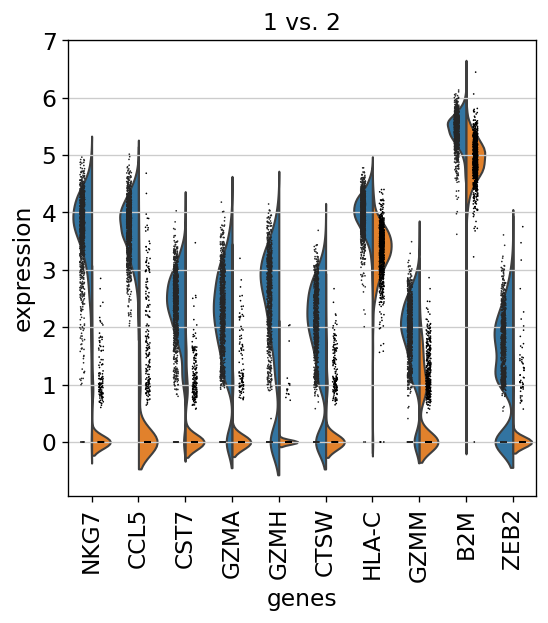

In [19]:
# 모든 데이터 집합에 걸쳐 바이올린과 동일한 유전자를 플롯.
sc.pl.rank_genes_groups_violin(adata, groups="1", n_genes=10)

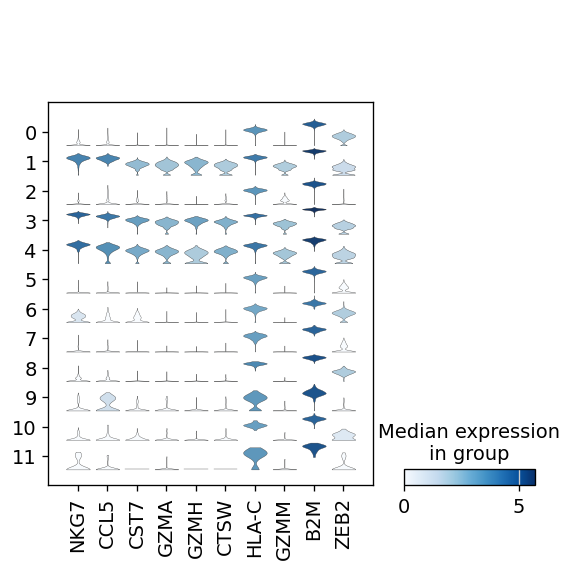

In [20]:
# numpy.recarray를 리스트로 변환.
mynames = [x[0] for x in adata.uns["rank_genes_groups"]["names"][:10]]
sc.pl.stacked_violin(adata, mynames, groupby="louvain_0.6")

## 조건에 따른 DGE 분석

하나의 클러스터 내에서 조건에 따라 어떤 유전자가 차등적으로 발현되는지에 대한 답을 구하는 방법을 알아보죠. 예를 들면 특정 세포 유형에서 환자와 대조군에서 어떤 유전자가 가장 많은 영향을 받는지 알고 싶다고 가정하는 것입니다. 

분석을 위해서는 먼저 원하는 세포 클러스터에 대한 데이터만 하위 집합하고 비교 변수(현재 우리의 경우 `Covid`과 `Ctrl`)로 `type` 값을 변경합니다.

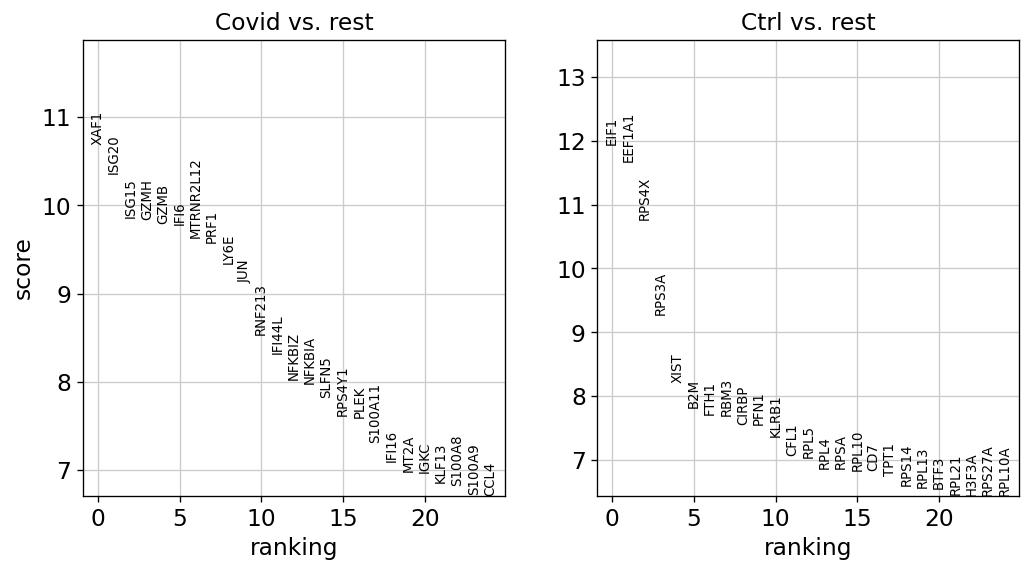

In [21]:
cl1 = adata[adata.obs["louvain_0.6"] == "4", :]
cl1.obs["type"].value_counts()

sc.tl.rank_genes_groups(cl1, "type", method="wilcoxon", key_added="wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

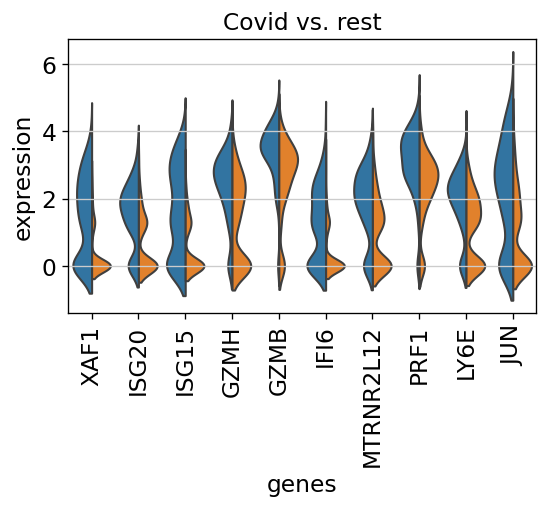

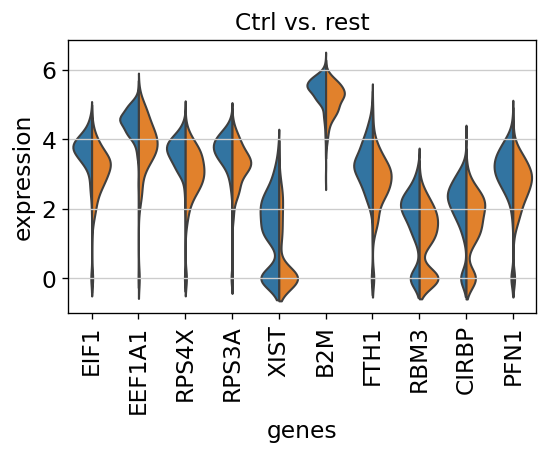

In [22]:
with rc_context({"figure.figsize": (5, 3)}):
    sc.pl.rank_genes_groups_violin(
        cl1, n_genes=10, key="wilcoxon", split=True, use_raw=False, size=0
    )

또한 모든 클러스터에서 이러한 유전자를 유형별로 분할해 다른 세포에서도 유전자가 상향/하향 조절되는지 확인할 수 있습니다.

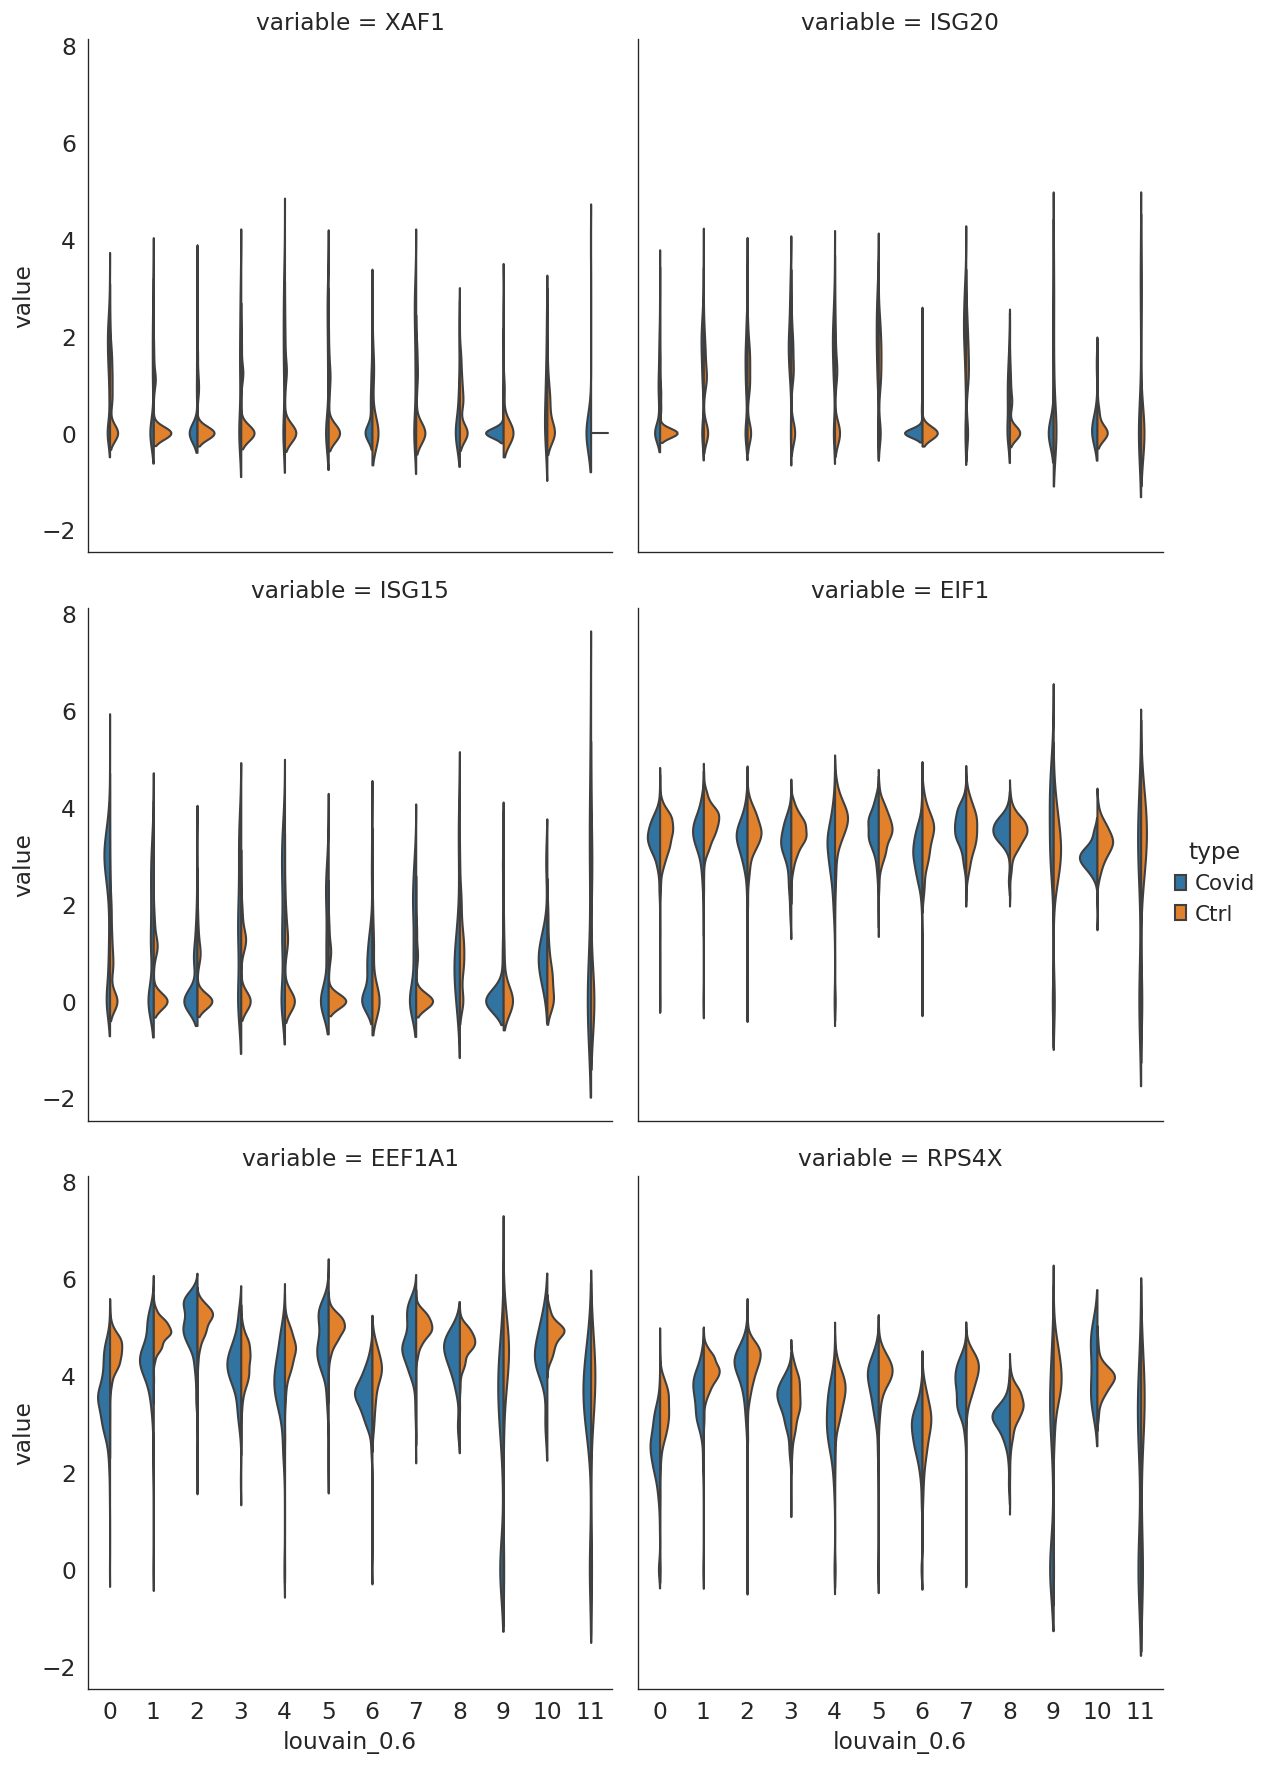

In [23]:
genes1 = sc.get.rank_genes_groups_df(cl1, group="Covid", key="wilcoxon")["names"][:3]
genes2 = sc.get.rank_genes_groups_df(cl1, group="Ctrl", key="wilcoxon")["names"][:3]
genes = genes1.tolist() + genes2.tolist()
df = sc.get.obs_df(adata, genes + ["louvain_0.6", "type"], use_raw=False)
df2 = df.melt(id_vars=["louvain_0.6", "type"], value_vars=genes)

with sns.axes_style("white"):
    ax = sns.catplot(
        x="louvain_0.6",
        y="value",
        hue="type",
        kind="violin",
        inner=None,
        split=True,
        col="variable",
        col_wrap=2,
        data=df2,
    )

plt.show()

위 결과를 보면 상위 DEG 중에는 성염색체 관련 유전자가 많이 있습니다. 이것은 시료의 성별 분포가 불균형했기 때문이며 코로나 바이러스 감염 여부와는 관련이 없습니다.

## 성염색체 유전자 데이터 제거

시료의 성별 불균형으로 인한 편향성을 제거하기 위해 성염색체 관련 유전자를 제거합니다. 다시 바이오마트(biomart)패키지를 사용해 알려진 성염색체의 목록을 불러오고 데이터에서 제외시킵니다. 

In [24]:
annot = sc.queries.biomart_annotations(
    "hsapiens",
    [
        "ensembl_gene_id",
        "external_gene_name",
        "start_position",
        "end_position",
        "chromosome_name",
    ],
).set_index("external_gene_name")

chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrX_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "X"])

sex_genes = chrY_genes.union(chrX_genes)
all_genes = cl1.var.index.tolist()
keep_genes = [x for x in all_genes if x not in sex_genes]
cl1 = cl1[:, keep_genes].copy()
print(f"전체 유전자의 수: {len(all_genes)}")
print(f"알려진 성염색체 유전자의 수: {len(sex_genes)}")
print(f"남겨진 유전자의 수: {len(keep_genes)}")

전체 유전자의 수: 19094
알려진 성염색체 유전자의 수: 544
남겨진 유전자의 수: 18550


이제 다시 DEG 찾기를 실행합니다.

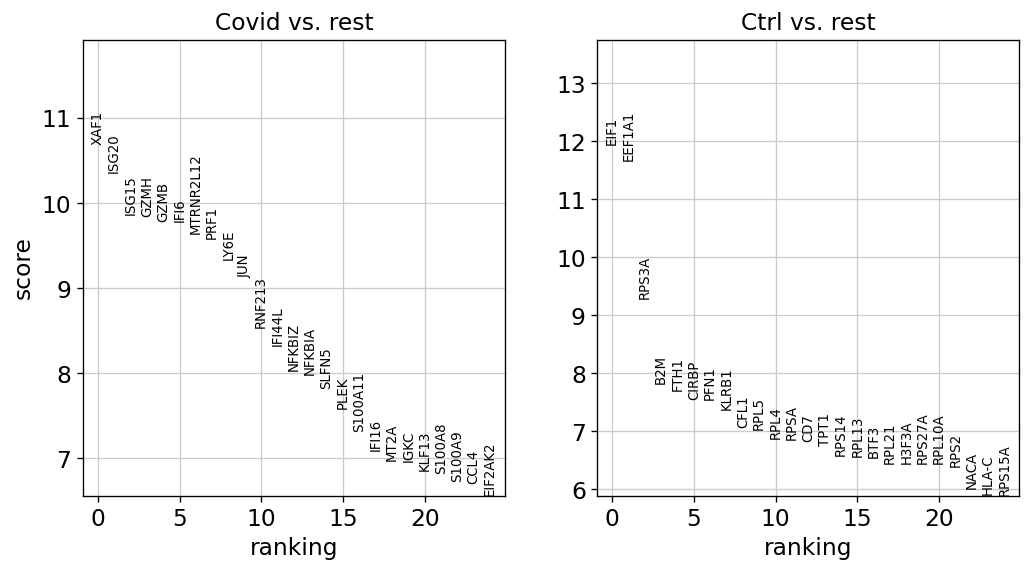

In [26]:
sc.tl.rank_genes_groups(cl1, "type", method="wilcoxon", key_added="wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

## 샘플별 배치 효과

`Covid` 과 대조군(`Control`) 사이의 DEG를 찾고 그룹 안에서 개인별로 상위 DGE가 어떻게 표현되는지 확인해봅니다.

Covid vs Ctrl


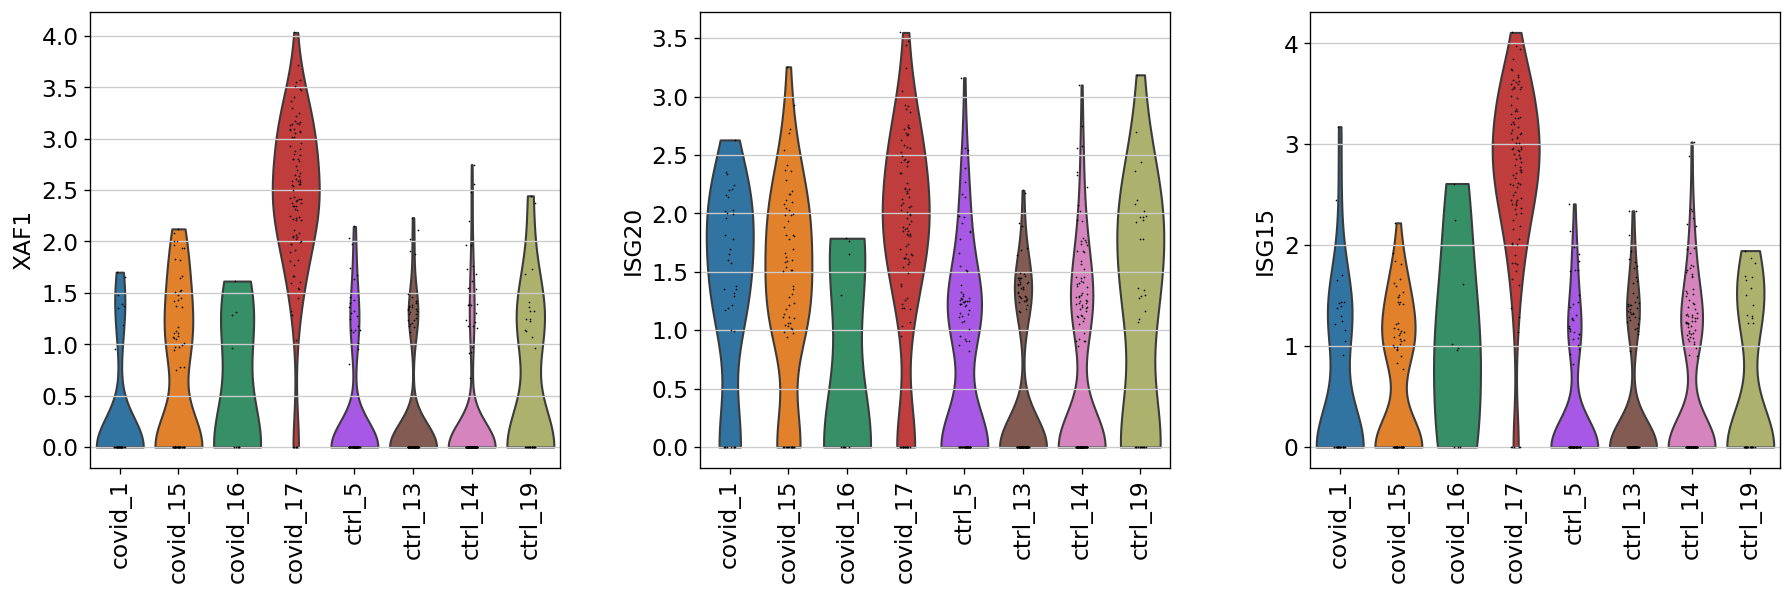

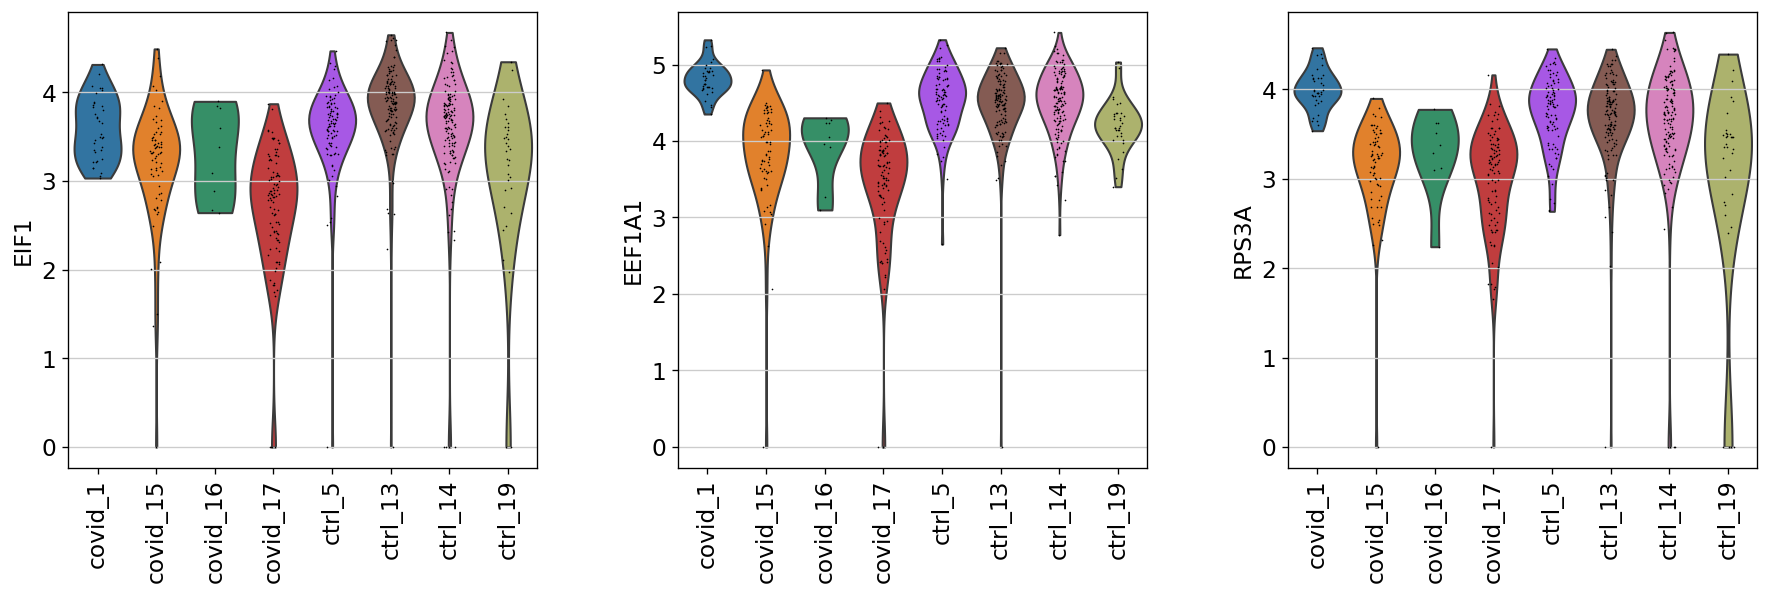

In [27]:
genes1 = sc.get.rank_genes_groups_df(cl1, group="Covid", key="wilcoxon")["names"][:4]
genes2 = sc.get.rank_genes_groups_df(cl1, group="Ctrl", key="wilcoxon")["names"][:4]
# genes = genes1.tolist() + genes2.tolist()

print("Covid vs Ctrl")
sc.pl.violin(cl1, genes1[:3], groupby="sample", rotation=90)
sc.pl.violin(cl1, genes2[:3], groupby="sample", rotation=90)

위 결과에서 보이듯이 `Covid`에서 DEG로 검출된 유전자가 한 명의 환자(`covid_17`)에게만 값이 높습니다. 닷플랏을 그려서 좀 더 확인해보죠.

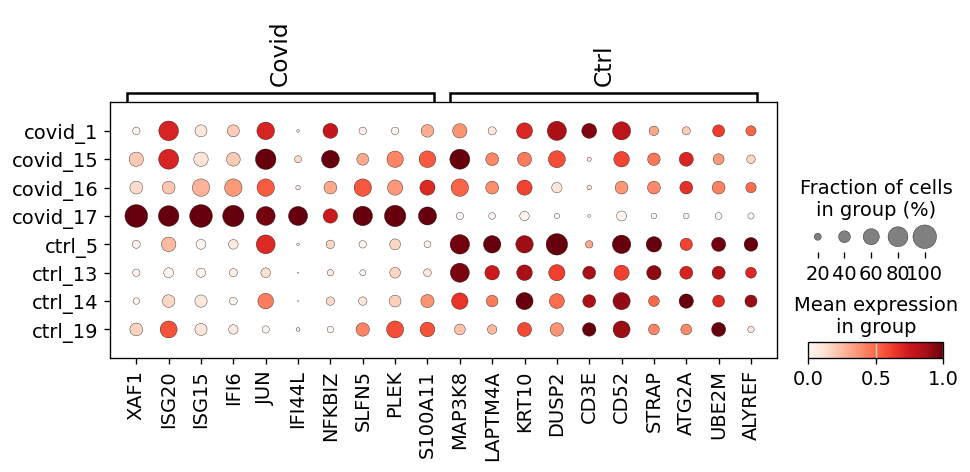

In [28]:
sc.tl.filter_rank_genes_groups(
    cl1,
    # min_in_group_fraction=0.2,
    # max_out_group_fraction=0.2,
    key="wilcoxon",
    key_added="wilcoxon_filtered",
)

sc.pl.rank_genes_groups_dotplot(
    cl1,
    groupby="sample",
    standard_scale="var",
    n_genes=10,
    key="wilcoxon_filtered",
    dendrogram=False,
)

닷플랏을 보면 분명 `covid_17` 샘플에서만 높게 발현되는 유전자의 패턴이 보입니다. 이상하군요. 각 샘플의 수를 확인해보죠.


In [29]:
cl1.obs["sample"].value_counts()

sample
ctrl_14     146
ctrl_13     132
covid_17    101
ctrl_5       93
covid_15     70
covid_1      37
ctrl_19      34
covid_16      9
Name: count, dtype: int64

위 출력을 보면 다른 환자에 비해 `covid_17` 환자의 샘플 수가 현저히 많아서 발생한 현상이라는 것을 알 수 있습니다.

### 다운 샘플링

DEG 분석을 할때 반드시 고려해야 할 사항은 샘플당 동일한 갯수의 세포를 사용해야 결과가 단일 샘플에 의해 영향받지 않는다는 것입니다. 따라서 이 경우에는 모든 샘플을 34개의 세포로 다운 샘플링합니다.

In [30]:
target_cells = 37

tmp = [cl1[cl1.obs["sample"] == s] for s in cl1.obs["sample"].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells)

cl1_sub = tmp[0].concatenate(*tmp[1:])

cl1_sub.obs["sample"].value_counts()

sample
covid_1     37
covid_15    37
covid_17    37
ctrl_5      37
ctrl_13     37
ctrl_14     37
ctrl_19     34
covid_16     9
Name: count, dtype: int64

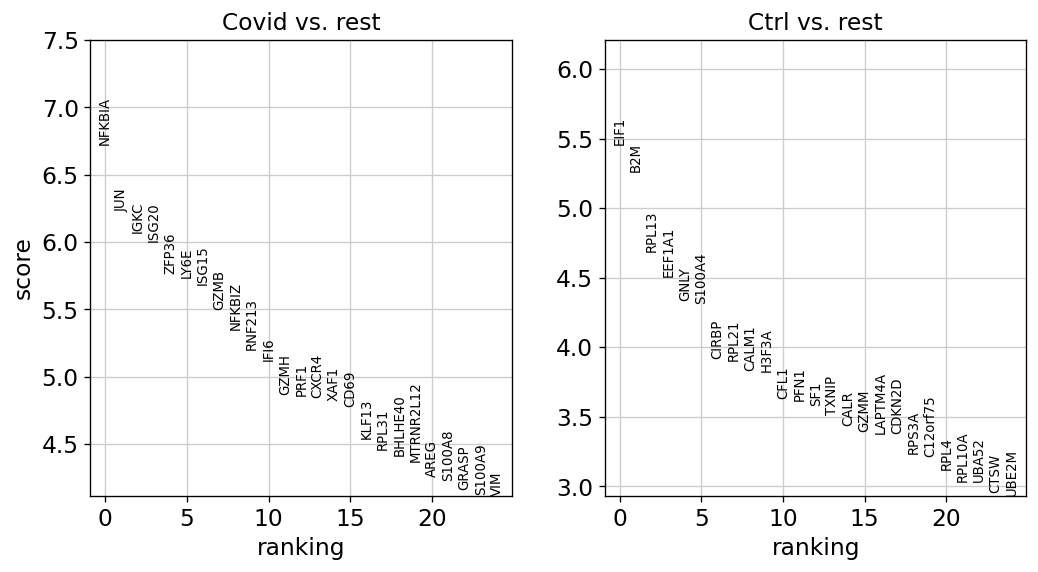

In [31]:
sc.tl.rank_genes_groups(cl1_sub, "type", method="wilcoxon", key_added="wilcoxon")
sc.pl.rank_genes_groups(cl1_sub, n_genes=25, sharey=False, key="wilcoxon")

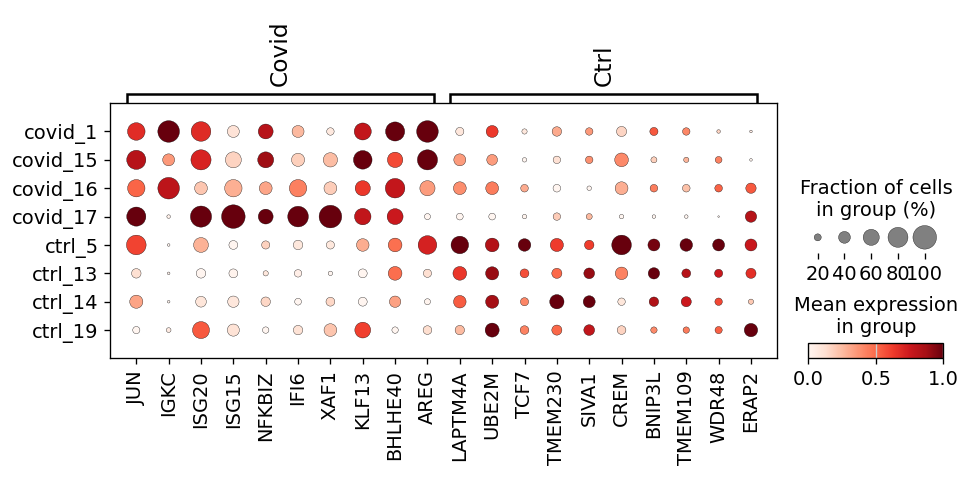

In [32]:
sc.tl.filter_rank_genes_groups(
    cl1_sub,
    key="wilcoxon",
    key_added="wilcoxon_filtered",
)

sc.pl.rank_genes_groups_dotplot(
    cl1_sub,
    groupby="sample",
    standard_scale="var",
    n_genes=10,
    key="wilcoxon_filtered",
    dendrogram=False,
)

훨씬 나아졌습니다. 하지만 여전히 한 환자에 의해 지배되는 일부 유전자가 있다는 것을 알 수 있습니다. 

이런 샘플의 배치 효과 문제를 해결하는 방법에는 여러 가지가 있지만 여기서는 다루지 않습니다. 자세한 것은 [sc-best-practice](https://www.sc-best-practices.org/conditions/differential_gene_expression.html)을 참고하세요.

# 저장하기

이후 분석을 위해 데이터를 저장하고 마무리 하겠습니다.

In [42]:
adata.write_h5ad(
    "./output/covid/results/scanpy_covid_qc_dr_sc_cl.h5ad",
    compression="gzip",
)

# 나가며

이번 글을 통해 `scanpy`로 세포를 클러스터링하고 각 세포 집단의 고유한 기능적 특성을 파악하는 방법을 배웠습니다. 이 분야의 분석도구는 계속 발전중이며 앞으로 더욱 정교한 알고리즘과 분석 도구가 나올 것입니다. 그러니 항상 새로운 알고리즘과 도구를 시도해보세요. 다음 글에서는 세포 클러스터에 대한 주석(annotation)을 부여하고 유전자 발현을 비교 분석하는 방법에 대해서 살펴보겠습니다.